# The Fourth Circle: Neural Networks, Part One 
## Multilayer Perceptron

<br/>
Jiří Fejlek

2026-01-24
<br/>


## Table of Contents

- [Heart Disease Datasets (Cleveland, Hungary, Switzerland, and the VA Long Beach)](#heart)
- [Perceptron](#perceptron)
    - [Rosenblatt’s Perceptron](#rperceptron)
    - [Logistic Regression](#logistic_reg)
        - [Logistic Regression in PyTorch](#logistic_reg_pytorch)
- [Multilayer Perceptron](#multi-perceptron)
    - [Activation Functions](#activf)
    - [Weights Initialization](#weights)
    - [Training Deep Neural Networks](#training)
        - [Momentum](#momentum)
        - [Evaluating Test Set Performance](#test)
        - [Weight Decay (L2 Regularization)](#l2)
        - [L1 Regularization](#l1)
        - [Dropout](#dropout)
        - [Gradient Clipping](#grad_clipping)
        - [Batch Normalization](#batch_norm)
    - [Model Validation](#valid)
- [References](#references)

The fourth project of this cycle is dedicated to neural networks and deep learning. This is naturally a vast subject, and hence, we will split the topic into several parts. We will start chronologically with the simplest neural network: a multilayer perceptron. We will also have a look at some popular techniques used for training the neural networks, which we will apply in the future projects.

## Heart Disease Datasets (Cleveland, Hungary, Switzerland, and the VA Long Beach) <a class="anchor" id="heart"></a>

We will again return to the dataset from the Second Circle, Part One obtained from https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data, based on four studies (Cleveland Clinic in Cleveland, Ohio; Hungarian Institute of Cardiology in Budapest, Hungary; Veterans Administration Medical Center in Long Beach, California; University Hospitals in Zurich and Basel, Switzerland) [[1](#1)]. The goal is to distinguish the patients with heart disease. The variables in the dataset are as follows.

* **age** 
* **sex** - age (at the time of examination)
* **dataset** - Cleveland, Hungary, Switzerland, and the VA Long Beach
* **cp** - chest pain type (typical angina, atypical angina, non-anginal, asymptomatic)
* **trestbps** - resting blood pressure in mm Hg 
* **chol** - serum cholesterol in mg/dl 
* **fbs** - fasting blood sugar > 120 mg/dl (True/False)
* **restecg** - resting electrocardiographic results (normal, ST-T abnormality, LV hypertrophy)
* **thalach** - maximum heart rate achieved
* **exang** -  exercise-induced angina (True/ False)
* **oldpeak** - ST depression induced by exercise relative to rest
* **slope** -  the slope of the peak exercise ST segment (flat, downsloping, upsloping)
* **ca** - number of major vessels (0-3) colored by fluoroscopy
* **thal** - thallium heart scan defect (normal, fixed defect, reversible defect)
* **num** -  diagnosis of heart disease (0 = no heart disease; 1,2,3,4 = stages of heart disease)

Let us load the dataset, and prepare the data for analysis, repeating the steps we did in the Second Circle Part One.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from missforest import MissForest

from sklearn.metrics import (accuracy_score, balanced_accuracy_score, roc_curve, roc_auc_score, log_loss, brier_score_loss, f1_score, matthews_corrcoef, cohen_kappa_score)
from sklearn.calibration import calibration_curve  
from sklearn.model_selection import KFold

np.set_printoptions(legacy='1.25')

In [2]:
# load the dataset
heart = pd.read_csv('C:/Users/elini/Desktop/nine circles 2/heart_disease_uci.csv')

# replace 0 with NaN and remove duplicates
heart.loc[heart['chol'] == 0,'chol'] = np.nan
heart.loc[heart['trestbps'] == 0,'trestbps'] = np.nan
heart_red = heart.drop(axis = 0, index = [405,907]).reset_index()

# prepare for missForrest imputation
heart_imp = heart_red[['age','sex','dataset','cp','trestbps','chol','fbs','restecg','thalch','exang','oldpeak','slope', 'thal']].copy()
heart_imp['sex'] = heart_imp['sex'].map({'Male': 1, 'Female': 0})
heart_imp['dataset'] = heart_imp['dataset'].map({'Cleveland': 0, 'Hungary': 1, 'Switzerland': 2, 'VA Long Beach': 3})
heart_imp['cp'] = heart_imp['cp'].map({'asymptomatic': 0, 'typical angina': 1, 'atypical angina': 2, 'non-anginal': 3})
heart_imp['fbs'] = heart_imp['fbs'].map({True: 1, False: 0})
heart_imp['restecg'] = heart_imp['restecg'].map({'normal': 0, 'lv hypertrophy': 1, 'st-t abnormality': 2})
heart_imp['exang'] = heart_imp['exang'].map({True: 1, False: 0})
heart_imp['slope'] = heart_imp['slope'].map({'flat': 0, 'downsloping': 1, 'upsloping': 2})
heart_imp['thal'] = heart_imp['thal'].map({'normal': 0, 'reversable defect': 1, 'fixed defect': 2})

categorical_variables_heart = ['sex','dataset','cp','fbs','restecg','exang','slope','thal']

# imputation
np.random.seed(123)
MissForest_imputation = MissForest(categorical=categorical_variables_heart)
MissForest_imputation._verbose = 0

MissForest_imputation.fit(x = heart_imp)
heart_imp_MissForest = heart_imp.copy()

heart_imp_MissForest =  MissForest_imputation.transform(x = heart_imp)

# final dataset
heart_final = heart_imp_MissForest.copy()
heart_final['heart_disease'] = (heart['num'] > 0).astype(int) 
heart_final['dataset'] = heart_final['dataset'].map({0: 'Clv', 1: 'Hun', 2: 'Swit', 3: 'VA'})
heart_final['cp'] = heart_final['cp'].map({0: 'asymp', 1: 'typ', 2: 'atyp', 3: 'nonang'})
heart_final['restecg'] = heart_final['restecg'].map({0: 'normal', 1: 'hypertrophy', 2: 'stt'})
heart_final['slope'] = heart_final['slope'].map({0: 'flat', 1: 'down', 2: 'up'})
heart_final['thal'] = heart_final['thal'].map({0: 'normal', 1: 'rev', 2: 'fixed'})

heart_final = pd.concat([heart_final,pd.get_dummies(heart_final[['cp','restecg','slope','thal']], dtype=int)], axis=1)
heart_final = heart_final[['age','sex','cp_typ','cp_atyp','cp_nonang','restecg_hypertrophy','restecg_stt',\
                           'thalch','exang','trestbps','oldpeak','fbs','chol','slope_down','slope_up','thal_rev','thal_fixed','heart_disease']]

Lastly, we will standardize the dataset.

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
heart_final_scaled = pd.DataFrame(scaler.fit(X = heart_final.iloc[:,range(0,17)]).transform(X = heart_final.iloc[:,range(0,17)]))
heart_final_scaled.columns = ['age','sex','cp_typ','cp_atyp','cp_nonang','restecg_hypertrophy','restecg_stt',\
                           'thalch','exang','trestbps','oldpeak','fbs','chol','slope_down','slope_up','thal_rev','thal_fixed']

heart_final_scaled = pd.concat([heart_final_scaled ,heart_final['heart_disease']], axis = 1)
heart_final_scaled

,age,sex,cp_typ,cp_atyp,cp_nonang,restecg_hypertrophy,restecg_stt,thalch,exang,trestbps,oldpeak,fbs,chol,slope_down,slope_up,thal_rev,thal_fixed,heart_disease
0,1.006537,0.515952,4.353909,-0.481887,-0.532838,1.970528,-0.490449,0.489089,-0.759815,0.712845,1.360348,2.377430,-0.236004,3.683942,-0.532838,-0.514259,4.353909,0
1,1.430829,0.515952,-0.229679,-0.481887,-0.532838,1.970528,-0.490449,-1.177237,1.316109,1.547181,0.605129,-0.420622,0.767302,-0.271448,-0.532838,-0.514259,-0.229679,1
2,1.430829,0.515952,-0.229679,-0.481887,-0.532838,1.970528,-0.490449,-0.344074,1.316109,-0.677713,1.643555,-0.420622,-0.311725,-0.271448,-0.532838,1.944544,-0.229679,1
3,-1.751359,0.515952,-0.229679,-0.481887,1.876744,-0.507478,-0.490449,1.957043,-0.759815,-0.121490,2.493175,-0.420622,0.085811,3.683942,-0.532838,-0.514259,-0.229679,0
4,-1.327067,-1.938163,-0.229679,2.075177,-0.532838,1.970528,-0.490449,1.361926,-0.759815,-0.121490,0.510727,-0.420622,-0.784982,-0.271448,1.876744,-0.514259,-0.229679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,0.051881,-1.938163,-0.229679,-0.481887,-0.532838,-0.507478,2.038947,0.647787,-0.759815,-0.288357,-0.810905,2.377430,1.657025,-0.271448,-0.532838,-0.514259,-0.229679,1
914,0.900464,0.515952,4.353909,-0.481887,-0.532838,-0.507478,2.038947,0.370800,-0.759815,-0.160633,-0.503613,-0.420622,-2.015450,-0.271448,-0.532838,-0.514259,-0.229679,1
915,0.157954,0.515952,-0.229679,-0.481887,-0.532838,-0.507478,2.038947,-1.494633,-0.759815,-0.566469,-0.810905,2.377430,-0.425306,-0.271448,-0.532838,-0.514259,4.353909,1
916,0.476173,0.515952,-0.229679,-0.481887,-0.532838,1.970528,-0.490449,-0.042651,-0.759815,0.356116,-0.621401,2.377430,2.641400,-0.271448,-0.532838,-0.514259,-0.229679,0


## Perceptron <a class="anchor" id="perceptron"></a>

We will start with the simplest neural network aimed for solving binary classification tasks that consists of just one neuron, the so-called *perceptron*.  Let us first introduce the original perceptron  by Frank Rosenblatt from 1957.

### Rosenblatt’s Perceptron <a class="anchor" id="rperceptron"></a>

Let us assume that classes are labeled as 0 and 1. The predicted class by Rosenblatt’s perceptron is given as [[2](#2)]
$$f(x;w,b) = H(w^Tx + b),$$ 
where  $w$ are weights, $b$ a bias term, and $H$ is Heaviside step function $H(x) = 1$ for $x \geq 0$ and $H(x) = 0$ for $x < 0$. Consequently, Rosenblatt’s perceptron is a linear classifier. Let us assume that the features $X$ include an intercept, and hence we can add the bias $b$ to the weights $w$. Weights for the perceptron are learned using Rosenblatt’s perceptron algorithm [[2](#2), [3](#3)] iteratively as
$$w_j = w_{j-1} + \eta(f(x;w_{j-1}) - y)x,$$
where $x$ is an observation from $X$, $y$ is its class, and $\eta$ is learning rate hyperparamereter. Consequently, the perceptron is learned by *stochastic gradient descent* (SGD) with the loss function $L(y,x) = \text{max}\{0, (1-2y)(w^Tx)\}$. The perceptron loss function is very similar to the hinge loss $L(y,x) = \text{max}\{0, 1 + (1-2y)(w^Tx)\}$ used in support vector machines. 

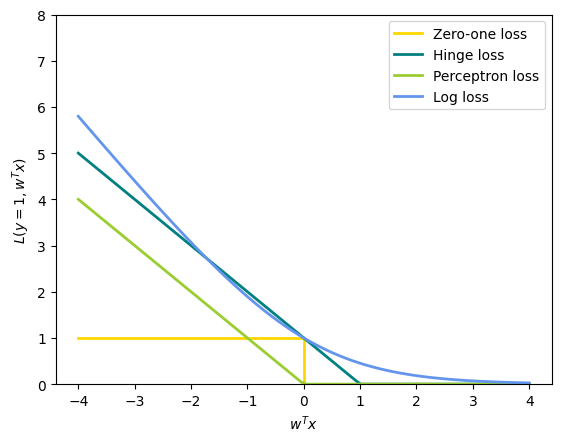

In [4]:
import matplotlib.pyplot as plt
import numpy as np

xmin, xmax = -4, 4
xx = np.linspace(xmin, xmax, 100)
lw = 2
plt.plot([xmin, 0, 0, xmax], [1, 1, 0, 0], color="gold", lw=lw, label="Zero-one loss")
plt.plot(xx, np.where(xx < 1, 1 - xx, 0), color="teal", lw=lw, label="Hinge loss")
plt.plot(xx, -np.minimum(xx, 0), color="yellowgreen", lw=lw, label="Perceptron loss")
plt.plot(xx, np.log2(1 + np.exp(-xx)), color="cornflowerblue", lw=lw, label="Log loss")

plt.ylim((0, 8))
plt.legend(loc="upper right")
plt.xlabel('$w^Tx$')
plt.ylabel("$L(y=1, w^Tx)$")
plt.show()

The difference is that for linearly separable data, the solution with the zero perceptron loss is any hyperplane that separates the data, whereas the hinge loss also penalizes when data points are close to the decision boundary. 

It can be shown that the Rosenblatt’s learning algorithm converges for linearly separable data. For non-separable data, the algorithm does not converge [[2](#2)], and the solution will cycle as the learning progresses. 

Let us run a simple SGD loop, recording the best model based on the perceptron loss and, say, the Matthews correlation, as a more interpretable performance metric.

In [5]:
def perceptron_loss(percpt, X, y):
    yXw = (1-2*y)*(np.concatenate(X @ np.transpose(percpt.coef_)) + percpt.intercept_)
    return np.maximum.reduce([yXw, np.zeros(len(yXw))], axis=0).mean()

In [6]:
from sklearn.linear_model import Perceptron
from copy import deepcopy

obs_heart = heart_final_scaled['heart_disease'].to_numpy() 
model_matrix = heart_final_scaled.iloc[:,range(0,17)].to_numpy()

np.random.seed(123)
perceptron_partial = Perceptron(eta0 = 1)

iter = 1000

matthews_scores = np.zeros(iter)
perceptron_scores = np.zeros(iter)
matthews_best = 0

for i in range(iter):
    rand_ind = np.random.choice(range(len(heart_final_scaled)), size=len(heart_final_scaled), replace=False)
    heart_shuffled = heart_final_scaled.iloc[rand_ind,:]
    perceptron_partial.partial_fit(heart_shuffled.iloc[:,range(0,17)], heart_shuffled['heart_disease'], classes= np.unique(obs_heart))
    perceptron_scores[i] = perceptron_loss(perceptron_partial,model_matrix,obs_heart)
    matthews_scores[i] = matthews_corrcoef(obs_heart,perceptron_partial.predict(heart_final_scaled.iloc[:,range(0,17)]))
    
    if matthews_scores[i] > matthews_best:
        perceptron_best = deepcopy(perceptron_partial)
        matthews_best = matthews_scores[i]

matthews_best

0.5686669926608112

The evolution of the perceptron loss and the Matthews correlation are as follows.

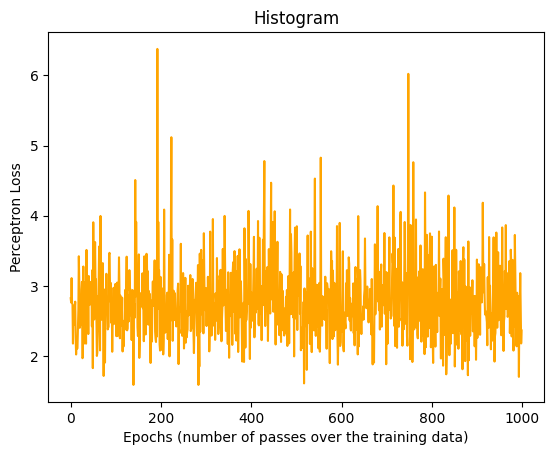

In [7]:
plt.plot(perceptron_scores, color = 'orange')
plt.title('Histogram')
plt.xlabel('Epochs (number of passes over the training data)')
plt.ylabel('Perceptron Loss');

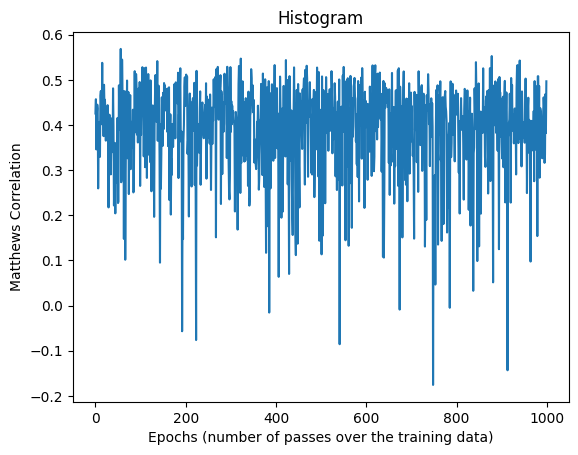

In [8]:
plt.plot(matthews_scores)
plt.title('Histogram')
plt.xlabel('Epochs (number of passes over the training data)')
plt.ylabel('Matthews Correlation');

Our data is not linearly separable, and hence, we observe that there is indeed very little convergence: the perceptron's performance jumps all around from epoch to epoch. To demonstrate that it is not just a matter of using too long gradient steps (learning rate), let us repeat the algorithm for $\eta = 10^{-4}$.

In [9]:
np.random.seed(123)
perceptron_partial = Perceptron(eta0 = 1e-6)

iter = 1000

matthews_scores2 = np.zeros(iter)
perceptron_scores2 = np.zeros(iter)
matthews_best2 = 0

for i in range(iter):
    rand_ind = np.random.choice(range(len(heart_final_scaled)), size=len(heart_final_scaled), replace=False)
    heart_shuffled = heart_final_scaled.iloc[rand_ind,:]
    perceptron_partial.partial_fit(heart_shuffled.iloc[:,range(0,17)], heart_shuffled['heart_disease'], classes= np.unique(obs_heart))
    perceptron_scores2[i] = perceptron_loss(perceptron_partial,model_matrix,obs_heart)
    matthews_scores2[i] = matthews_corrcoef(obs_heart,perceptron_partial.predict(heart_final_scaled.iloc[:,range(0,17)]))
    
    if matthews_scores2[i] > matthews_best2:
        perceptron_best2 = deepcopy(perceptron_partial)
        matthews_best2 = matthews_scores[i]

matthews_best2

0.5686669926608112

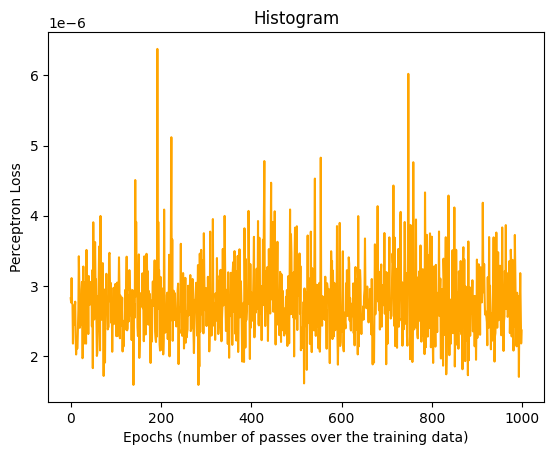

In [10]:
plt.plot(perceptron_scores2, color = 'orange')
plt.title('Histogram')
plt.xlabel('Epochs (number of passes over the training data)')
plt.ylabel('Perceptron Loss');        

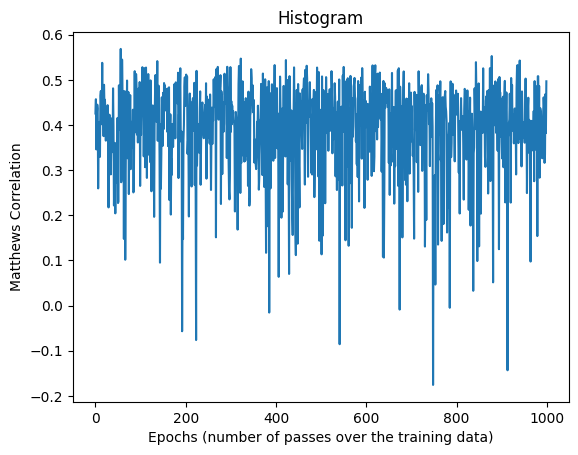

In [11]:
plt.plot(matthews_scores2)
plt.title('Histogram')
plt.xlabel('Epochs (number of passes over the training data)')
plt.ylabel('Matthews Correlation');

We observe that we actually obtained the same perceptron. 

In [12]:
np.abs(matthews_scores2 - matthews_scores).max()

0.0

This is because we ran both algorithms with the same randomization, and *Perceptron* initializes with zero weights (see line 244 in https://github.com/scikit-learn/scikit-learn/blob/d3898d9d5/sklearn/linear_model/_stochastic_gradient.py#L950). In addition, perceptrons $f(x;w) =  w^T x$ and  $f(x;w) =  \eta w^T x$ for some $\eta > 0$ provide the same predictions. And finally, all gradient updates are of the form  $w^T x + x_0$ and $\eta w^T x + \eta x_0$ for some missclassified $x_0$, respectively.  Consequently, both perceptrons have always the same weights up to a multiplicative constant: the learning rate $\eta.$

In [13]:
perceptron_best.coef_/perceptron_best2.coef_

array([[ 999999.99999999, 1000000.00000001,  999999.99999996,
        1000000.00000001, 1000000.00000003, 1000000.        ,
        1000000.        , 1000000.        , 1000000.00000001,
        1000000.00000004,  999999.99999998, 1000000.        ,
        1000000.00000004,  999999.99999999,  999999.99999998,
        1000000.        , 1000000.        ]])

Overall, the learning rate does not matter.  Let us check the performance of the best perceptron we have found.

In [14]:
accuracy_score(obs_heart,(perceptron_best.predict(heart_final_scaled.iloc[:,range(0,17)])))

0.7875816993464052

In [15]:
balanced_accuracy_score(obs_heart,(perceptron_best.predict(heart_final_scaled.iloc[:,range(0,17)])))

0.7824275014403688

In [16]:
f1_score(obs_heart,(perceptron_best.predict(heart_final_scaled.iloc[:,range(0,17)])))

0.8123195380173244

In [17]:
f1_score(obs_heart,(perceptron_best.predict(heart_final_scaled.iloc[:,range(0,17)])),pos_label=0)

0.7553324968632371

In [18]:
matthews_corrcoef(obs_heart,(perceptron_best.predict(heart_final_scaled.iloc[:,range(0,17)])))

0.5686669926608112

In [19]:
cohen_kappa_score(obs_heart,(perceptron_best.predict(heart_final_scaled.iloc[:,range(0,17)])))

0.5679280531780857

We can check the generalization of the model via cross-validation.

In [20]:
# cross-validation
np.random.seed(123)

rep = 50
folds = 10
kf = KFold(n_splits=10) # create folds

metrics_cv_heart_perceptron =  pd.DataFrame(index=range(rep*folds),columns = ['Accuracy', 'Balanced Accuracy', 'F1-score', 'F1-score (for negatives)','Matthews correlation',"Cohen's kappa"])

k = 0

for i in range(rep):
    
    idx_cv = np.random.choice([*range(len(heart_final))],len(heart_final), replace=False)
    
    for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
        
        train_set = idx_cv[train_index]
        test_set = idx_cv[test_index]
        
        heart_train = heart_final.iloc[train_set]
        heart_test = heart_final.iloc[test_set]

        # scaler
        scaler_new = StandardScaler()
        scaler_new.fit(X = heart_train.iloc[:,range(0,17)])

        heart_train_scaled = scaler_new.transform(X = heart_train.iloc[:,range(0,17)])
        heart_test_scaled = scaler_new.transform(X = heart_test.iloc[:,range(0,17)])
        heart_train_scaled = pd.concat([pd.DataFrame(heart_train_scaled), heart_train['heart_disease'].reset_index(drop = True)], axis = 1)
        heart_test_scaled =  pd.concat([pd.DataFrame(heart_test_scaled), heart_test['heart_disease'].reset_index(drop = True)], axis = 1)

        matthews_scores_new = np.zeros(500)
        matthews_best_new = 0

        perceptron_new = Perceptron(eta0 = 1)

        for l in range(500):
            rand_ind = np.random.choice(range(len(heart_train_scaled)), size=len(heart_train_scaled), replace = False)
            heart_train_shuffled = heart_train_scaled.iloc[rand_ind,:]
            perceptron_new.partial_fit(heart_train_shuffled.iloc[:,range(0,17)], heart_train_shuffled['heart_disease'], classes = np.unique(obs_heart))
            matthews_scores_new[l] = matthews_corrcoef(heart_train_scaled['heart_disease'],perceptron_new.predict(heart_train_scaled.iloc[:,range(0,17)]))
            
            if matthews_scores_new[l] > matthews_best_new:
                perceptron_best_new = deepcopy(perceptron_new)
                matthews_best_new = matthews_scores_new[l]

        
        metrics_cv_heart_perceptron.iloc[k,0] = accuracy_score(heart_test_scaled['heart_disease'],perceptron_best_new.predict(heart_test_scaled.iloc[:,range(0,17)]))
        metrics_cv_heart_perceptron.iloc[k,1] = balanced_accuracy_score(heart_test_scaled['heart_disease'],perceptron_best_new.predict(heart_test_scaled.iloc[:,range(0,17)]))
        metrics_cv_heart_perceptron.iloc[k,2] = f1_score(heart_test_scaled['heart_disease'],perceptron_best_new.predict(heart_test_scaled.iloc[:,range(0,17)]))
        metrics_cv_heart_perceptron.iloc[k,3] = f1_score(heart_test_scaled['heart_disease'],perceptron_best_new.predict(heart_test_scaled.iloc[:,range(0,17)]),pos_label=0)
        metrics_cv_heart_perceptron.iloc[k,4] = matthews_corrcoef(heart_test_scaled['heart_disease'],perceptron_best_new.predict(heart_test_scaled.iloc[:,range(0,17)]))
        metrics_cv_heart_perceptron.iloc[k,5] = cohen_kappa_score(heart_test_scaled['heart_disease'],perceptron_best_new.predict(heart_test_scaled.iloc[:,range(0,17)]))

        k = k + 1

metrics_cv_heart_perceptron.mean()

Accuracy                    0.757292
Balanced Accuracy           0.752674
F1-score                    0.783395
F1-score (for negatives)     0.71832
Matthews correlation        0.509339
Cohen's kappa               0.504381
dtype: object

We observe that Rosenblatt’s perceptron is actually not a bad model for our data. However, there is little reason to consider Rosenblatt’s perceptron nowadays, since the linear support vector machine is essentially an improved version that introduces margin maximization to uniquely select the solution and better handles non-separable cases by introducing the soft margin.

Like a single classification tree, a single neuron, a perceptron, is more of a building block than a viable classifier by itself. Before we proceed to combine neurons to form a network, let us look again at logistic regression, now from the standpoint of neural networks.

### Logistic regression <a class="anchor" id="logistic_reg"></a>

As we have discussed, the original perceptron is defined as $f(x;w) = H(w^Tx)$, where $H$ is the Heavisine step function. But it is completely reasonable to consider other so-called *activation* functions. One obvious and popular choice is to pick the *sigmoid* function which we refered to as ilogit in the previous projects
$$f(x;w) =  \frac{e^{x^Tw}}{1+e^{x^Tw}} = \text{ilogit } (x^Tw ).$$
Using the fact that the sigmoid function maps monotonically the real line to the interval $(0,1)$, we can then assume a probabilistic model  $f(x;w) = P(Y = 1 \mid X  = x)$. If we then consider  the log loss (aka log-likelihood) for determining the optimal weights
$$L(y,p(x;w)) = y\text{ log }p(x;w) + (1-y)\text{ log }(1-p(x;w)),$$
we obtain a perceptron that corresponds to standard logistic regression. In addition, nothing prevents us from using SGD to minimize the log loss.

In [21]:
from sklearn.linear_model import SGDClassifier

np.random.seed(123)

log_reg_sgd = SGDClassifier(loss = 'log_loss', penalty = None, learning_rate = 'constant', eta0 = 1)

iter = 1000

log_scores = np.zeros(iter)
auc_scores = np.zeros(iter)
log_score_best = 1e12

for i in range(iter):
    rand_ind = np.random.choice(range(len(heart_final_scaled)), size=len(heart_final_scaled), replace=False)
    heart_shuffled = heart_final_scaled.iloc[rand_ind,:]
    log_reg_sgd.partial_fit(heart_shuffled.iloc[:,range(0,17)], heart_shuffled['heart_disease'], classes= np.unique(obs_heart))
    log_scores[i] = log_loss(obs_heart, log_reg_sgd.predict_proba(heart_final_scaled.iloc[:,range(0,17)])[:,1])
    auc_scores[i] = roc_auc_score(obs_heart, log_reg_sgd.predict_proba(heart_final_scaled.iloc[:,range(0,17)])[:,1])

    if log_scores[i] < log_score_best:
        log_reg_sgd_best = deepcopy(log_reg_sgd)
        log_score_best = log_scores[i]

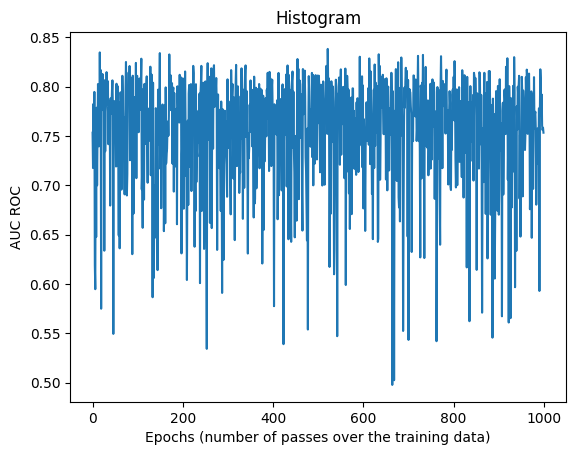

In [22]:
plt.plot(auc_scores)
plt.title('Histogram')
plt.xlabel('Epochs (number of passes over the training data)')
plt.ylabel('AUC ROC');

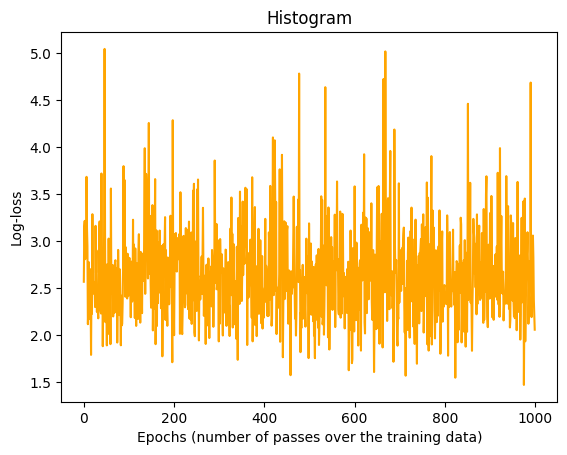

In [23]:
plt.plot(log_scores, color = 'orange')
plt.title('Histogram')
plt.xlabel('Epochs (number of passes over the training data)')
plt.ylabel('Log-loss');

We observe that the SGD struggles again, jumping quite a lot. However, unlike Rosenblatt’s Perceptron, lowering the (constant) learning rate directly influences the convergence profile.

In [24]:
np.random.seed(123)

log_reg_sgd = SGDClassifier(loss = 'log_loss', penalty = None, learning_rate = 'constant', eta0 = 1e-3)

iter = 1000

log_scores = np.zeros(iter)
auc_scores = np.zeros(iter)
log_score_best = 1e12

for i in range(iter):
    rand_ind = np.random.choice(range(len(heart_final_scaled)), size=len(heart_final_scaled), replace=False)
    heart_shuffled = heart_final_scaled.iloc[rand_ind,:]
    log_reg_sgd.partial_fit(heart_shuffled.iloc[:,range(0,17)], heart_shuffled['heart_disease'], classes= np.unique(obs_heart))
    log_scores[i] = log_loss(obs_heart, log_reg_sgd.predict_proba(heart_final_scaled.iloc[:,range(0,17)]))
    auc_scores[i] = roc_auc_score(obs_heart, log_reg_sgd.predict_proba(heart_final_scaled.iloc[:,range(0,17)])[:,1])

    if log_scores[i] < log_score_best:
        log_reg_sgd_best = deepcopy(log_reg_sgd)
        log_score_best = log_scores[i]

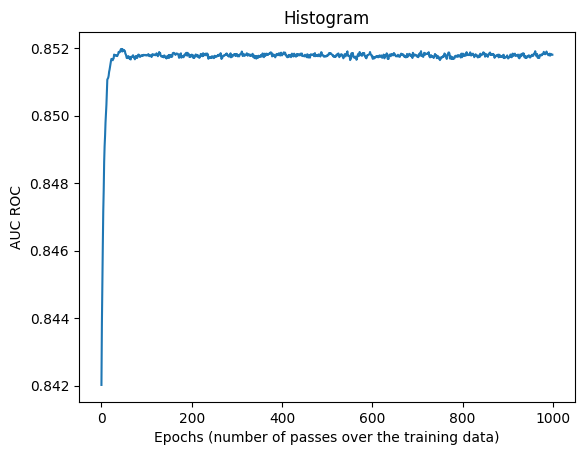

In [25]:
plt.plot(auc_scores)
plt.title('Histogram')
plt.xlabel('Epochs (number of passes over the training data)')
plt.ylabel('AUC ROC');

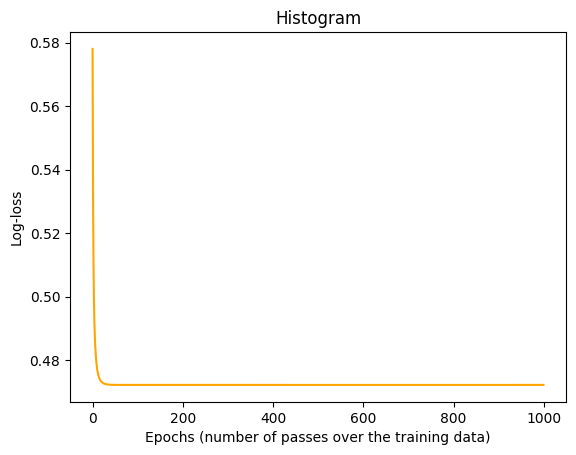

In [26]:
plt.plot(log_scores, color = 'orange')
plt.title('Histogram')
plt.xlabel('Epochs (number of passes over the training data)')
plt.ylabel('Log-loss');

Let us check our best "logistic" perceptron model.

In [27]:
log_loss(obs_heart, log_reg_sgd_best.predict_proba(heart_final_scaled.iloc[:,range(0,17)])[:,1])

0.4721865496540527

In [28]:
roc_auc_score(obs_heart, log_reg_sgd_best.predict_proba(heart_final_scaled.iloc[:,range(0,17)])[:,1])

0.8517764547724218

In [29]:
brier_score_loss(obs_heart, log_reg_sgd_best.predict_proba(heart_final_scaled.iloc[:,range(0,17)])[:,1])

0.15187695110648605

We observe that the progress of SGD is now much more reasonable. 

Instead of guessing an appropriate constant learning rate, we can gradually decrease the learning rate over time. For example, we can consider a simple learning scheme $\eta_i = \eta_0 (1+i)^\alpha$, where $\alpha$ < 0 (so-called polynomial decay). The value $\alpha = -0.5$ is often picked as a default due to its nice properties for convex optimization [[4](#4)] as we explain later.

In [30]:
np.random.seed(123)

eta0 = 0.1
power_t = -0.5
log_reg_sgd = SGDClassifier(loss = 'log_loss', penalty = None, learning_rate = 'constant', eta0 = eta0)

iter = 1000

log_scores = np.zeros(iter)
log_score_best = 1e12

for i in range(iter):
    rand_ind = np.random.choice(range(len(heart_final_scaled)), size=len(heart_final_scaled), replace=False)
    heart_shuffled = heart_final_scaled.iloc[rand_ind,:]
    log_reg_sgd.partial_fit(heart_shuffled.iloc[:,range(0,17)], heart_shuffled['heart_disease'], classes= np.unique(obs_heart))
    log_reg_sgd.eta0 = eta0 * pow(i+1, power_t)
    log_scores[i] = log_loss(obs_heart, log_reg_sgd.predict_proba(heart_final_scaled.iloc[:,range(0,17)]))
    auc_scores[i] = roc_auc_score(obs_heart, log_reg_sgd.predict_proba(heart_final_scaled.iloc[:,range(0,17)])[:,1])

    if log_scores[i] < log_score_best:
        log_reg_sgd_best = deepcopy(log_reg_sgd)
        log_score_best = log_scores[i]

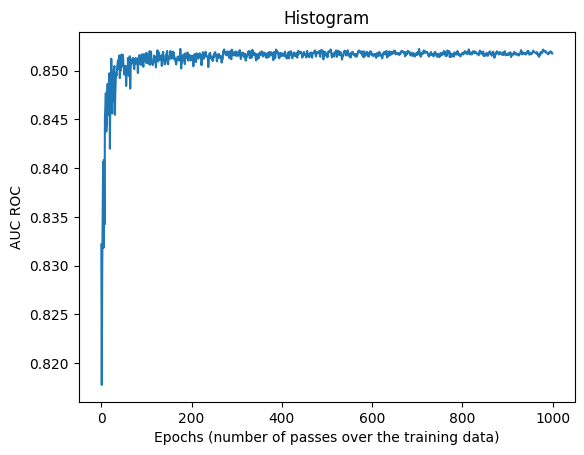

In [31]:
plt.plot(auc_scores)
plt.title('Histogram')
plt.xlabel('Epochs (number of passes over the training data)')
plt.ylabel('AUC ROC');

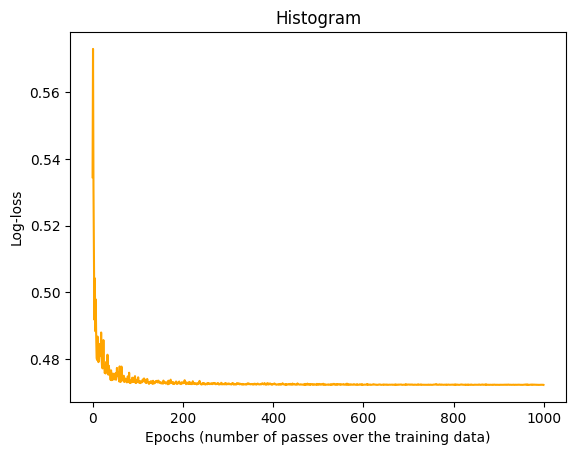

In [32]:
plt.plot(log_scores, color = 'orange')
plt.title('Histogram')
plt.xlabel('Epochs (number of passes over the training data)')
plt.ylabel('Log-loss');

It can be actually shown that the SGD algorithm converges almost surely (i.e., with probability one) to the optimum of a convex function with bounded derivative, provided that the learning rate decreases with an appropriate rate [[4](#4), [5](#5)]. 

In [33]:
log_reg_heart = smf.logit(formula='heart_disease ~ age + sex + cp_typ + cp_atyp + cp_nonang + restecg_hypertrophy + \
                          restecg_stt + thalch + exang + trestbps + oldpeak + fbs + chol + slope_down + slope_up + \
                          thal_rev + thal_fixed', data=heart_final_scaled)
log_reg_heart_fit = log_reg_heart.fit(disp=0)

log_loss(obs_heart, log_reg_heart_fit.predict())

0.4721862733067712

In [34]:
roc_auc_score(obs_heart, log_reg_heart_fit.predict())

0.8517476473977339

In [35]:
brier_score_loss(obs_heart, log_reg_heart_fit.predict())

0.15187301420299648

We notice that the SGD got quite close to the solution obtained by *smf.logit*. However, the number of iterations required in SGD is *much* higher than for the second-order Newton's method (i.e., a method that uses both the gradient and the Hessian) applied on the whole dataset, such as L-BFGS used in *smf.logit*. 

In [36]:
log_reg_heart.fit(disp=1);

Optimization terminated successfully.
         Current function value: 0.472186
         Iterations 6


To obtain a solution via our SGD with an objective lower than $1.01 \times 0.472186$, we need the following number of epochs.

In [37]:
np.where(log_scores < 1.01* 0.472186)[0][0]

27

This corresponds to

In [38]:
np.where(log_scores < 1.01* 0.472186)[0][0]*len(heart_final_scaled)

24786

individual iterations. However, these iterations are *much* computationally cheaper.

To provide some context on convergence rates, when sufficiently close to the optimum, the (non-stochastic) gradient descent (GD) converges to an optimum for a convex and twice differentiable objective function with optimal step lengths (so-called exact line search) at a linear rate: $\frac{\epsilon_{k+1}}{\epsilon_k}  \leq C$, where $\epsilon_k = |f(x^*) - f(x_k)|$ and $0 < C < 1$ is some constant. In other words, $\epsilon_k =  O(C^k)$ [[6](#6)]. Without exact line search under more general assumptions and provided that steps are small enough, convergence is sublinear: $\epsilon_k = O(1/k)$ [[5](#5)].

Newton's method, under suitable assumptions, when sufficiently close to the optimum, converges quadratically: $\frac{\epsilon_{k+1}}{\epsilon_k^2} \leq C$, i.e., $\epsilon_{k+1} \sim C \epsilon_k^2$. This is extremely fast convergence: the solution's precision roughly doubles in terms of digits in each step. For approximate Newton's methods (so-called quasi-Newton), such as L-BFGS (these methods do not use the exact Hessian, merely an estimate), this convergence is superlinear (i.e., $\frac{\epsilon_{k+1}}{\epsilon_k}  \rightarrow 0$) [[6](#6)]. 

On the other hand, SGD achieves sublinear convergence rates $\epsilon_k = O(\text{log } k/\sqrt{k})$ for convex functions with bounded derivatives, and with a polynomial-decay learning rate $\alpha = 1/2$. This result can improve to $\epsilon_k = O(1/k)$ under stronger assumptions [[5](#5)]. Interestingly, stochastic gradient descent can even attain linear convergence, for example, in overparametrized neural networks [[7](#7)]. 

Overall, Newton's methods converge much faster than GD and SGD. So why is SGD so popular for training neural networks? Well, computing Hessians (or their approximations) can be very computationally and memory intensive (and become prohibitive) for large datasets and complex models such as deep neural networks. In addition, the loss in such deep neural networks is no longer convex, and thus, quadratic convergence is no longer guaranteed. As for SGD vs. GD, again, SGD is better suited to large datasets. In addition, SGD is more robust to local minima and saddle points due to its non-deterministic nature. Lastly, we should note that while we now consider simple SGD, in which we train on one sample at a time, we can also use *mini-batch gradient descent* (MBGD),  in which we train the model on a subsample of the data, and the size of this subsample can be fine-tuned for a particular problem. This makes the decision between SGD and GD much more gradual in practice.

#### Logistic Regression in PyTorch <a class="anchor" id="logistic_reg_pytorch"></a>

To wrap up logistic regression and its connection to neural networks, we will implement it as a neural network in *PyTorch*. PyTorch is a powerful framework for implementing and training deep neural network architectures, allowing us to easily leverage advanced techniques such as parallel computations on GPUs and automatic differentiation (for efficient gradient calculations).

Neural networks in *PyTorch* are constructed as classes. We first define the architecture of our logistic regression neural network by combining linear transformation *nn.Linear* $y(x) = xA^T + b$  with elementwise sigmoid *nn.Sigmoid* $y(x) = \frac{1}{1 + e^{-x}}$. We also define a forward pass of the network, which is simply the evaluation of our combined transformation using *nn.Sequential*.

In [39]:
import torch
from torch import nn

class Logistic_Regression_Net(nn.Module):
    def __init__(self, input_size): # number of input features is input_size, we have one output for binary classification 
        super().__init__()
        self.log_reg_stack = nn.Sequential(
            nn.Linear(input_size, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        output = self.log_reg_stack(x)
        return output

In our case, we have 17 input features.

In [40]:
log_reg_nn = Logistic_Regression_Net(17)
print(log_reg_nn)

Logistic_Regression_Net(
  (log_reg_stack): Sequential(
    (0): Linear(in_features=17, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


Next, we will initialize the neural network's parameters (weights and biases). *PyTorch* will perform default initializations automatically, but especially in more complex architectures, it might be crucial to initialize the weights more carefully.

In [41]:
def init_weights(model):
    if isinstance(model, nn.Linear):
        nn.init.normal_(model.weight, mean = 0, std = 1) # weights randomly from N(0,1)
        nn.init.constant_(model.bias, 0) # biases as constant 0

In [42]:
torch.manual_seed(123)
log_reg_nn.apply(init_weights); # weight initialization
# log_reg_nn.log_reg_stack[0].apply(init_weights) # we can also initialize specifically a given layer, not just the whole network.

We can directly acces the values of parameters of each layer.

In [43]:
log_reg_nn.log_reg_stack[0].weight

Parameter containing:
tensor([[ 0.3374, -1.0205, -0.1690,  0.9178,  1.5810,  1.3010,  1.2753, -0.2010,
         -0.1606, -1.5723,  0.9666, -1.1481, -1.1589,  0.3255, -0.6315, -2.8400,
         -0.7849]], requires_grad=True)

In [44]:
log_reg_nn.log_reg_stack[0].bias

Parameter containing:
tensor([0.], requires_grad=True)

Next, we will define our loss function. We write the loss using *PyTorch* functions, such as *torch.log*, to obtain a formula that can be automatically differentiated via *torch.autograd*. A standard technique to obtain derivatives of a given function is to compute some finite difference approximations. However, these approximations can be imprecise (we have to choose a suitable step size and formula: forward, backward, central, and the order of the method) and are expensive to obtain (we have to evaluate the function multiple times).  Automatic differentiation obtains exact derivatives (up to machine precision) of the given computer code significantly faster by repeatedly applying the chain rule on elementary operations that the computer code consists of. 

In [45]:
def logistic_loss(y_true, y_pred):
    y_pred = torch.clamp(y_pred, 1e-8, 1 - 1e-8) # restrict the values of y_pred to ensure that log(y_pred) and log(1-y_pred) are always defined
    return (-1 * (y_true * torch.log(torch.flatten(y_pred)) + (1 - y_true) * torch.log(1 - torch.flatten(y_pred)))).sum()  

We also need to define the optimizer: SGD with a give learning rate,

In [46]:
optim_SGD =  torch.optim.SGD(log_reg_nn.parameters(), lr = 1e-3)

Lastly, we transform the dataset into the *PyTorch* tensor format and implement the training loop. We will use the *DataLoader* function to simplify the implementation of *batches* of data (for SGD, a batch is simply one observation from the training set).

In [47]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X = torch.from_numpy(heart_final_scaled.iloc[:,range(0,17)].values).type(torch.float32)
y = torch.from_numpy(heart_final_scaled['heart_disease'].values).type(torch.int32)

heart_pytorch_dataset = TensorDataset(X, y)
heart_loader = DataLoader(dataset = heart_pytorch_dataset, batch_size = 1, shuffle = True) 

In [48]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    loss_sum  = torch.tensor(0)
    
    for batch, (X, y) in enumerate(dataloader):
        
        pred_y = model(X) # forward pass
        loss = loss_fn(y, pred_y) # loss evaluation 

        # Backpropagation
        loss.backward() # gradient evaluation
        optimizer.step() # SGD step
        optimizer.zero_grad() # zero out the gradients

        loss_sum = loss_sum + loss 
        
    return  loss_sum.detach()/size

In [49]:
import time

torch.manual_seed(123)

n_epochs = 100
loss_epochs = np.zeros(n_epochs) 

start = time.time()
for t in range(n_epochs):
    loss_epochs[t] = train_loop(heart_loader, log_reg_nn, logistic_loss, optim_SGD)

end = time.time()
print(end - start)     

57.94406533241272


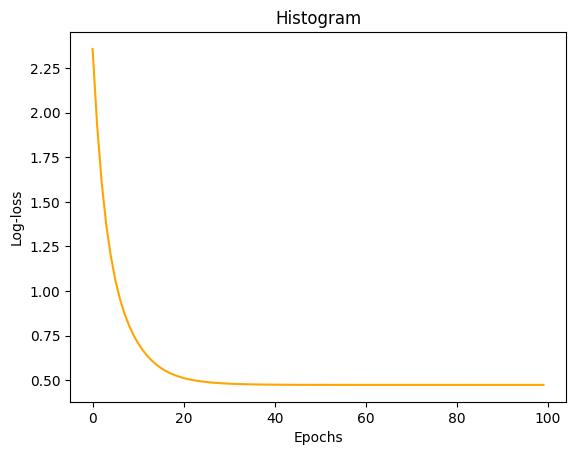

In [50]:
plt.plot(loss_epochs, color = 'orange')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

We can also introduce a varying learning rate via *lr_scheduler*.

In [51]:
def train_loop2(dataloader, model, loss_fn, optimizer, scheduler):
    size = len(dataloader.dataset)
    model.train()

    loss_sum  = 0
    
    for batch, (X, y) in enumerate(dataloader):
        
        pred_y = model(X) # forward pass
        loss = loss_fn(y, pred_y) # loss evaluation 

        # Backpropagation
        loss.backward() # gradient evaluation
        optimizer.step() # SGD step
        optimizer.zero_grad() # zero out the gradients

        loss_sum = loss_sum + loss 
    
    scheduler.step() # learning rate step
    learning_rate = scheduler.get_last_lr() 
    return  loss_sum.detach()/size, learning_rate[0]     

In [52]:
torch.manual_seed(123)
log_reg_nn.apply(init_weights) # reset the weights of the NN

optim_SGD =  torch.optim.SGD(log_reg_nn.parameters(), lr = 1e-2)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optim_SGD, total_iters = n_epochs, power = 2)

n_epochs = 100
loss_epochs = np.zeros(n_epochs) 
learning_rates = np.zeros(n_epochs)

start = time.time()
for t in range(n_epochs):
    loss_epochs[t], learning_rates[t] = train_loop2(heart_loader, log_reg_nn, logistic_loss, optim_SGD, scheduler)
end = time.time()
print(end - start) 

43.77144646644592


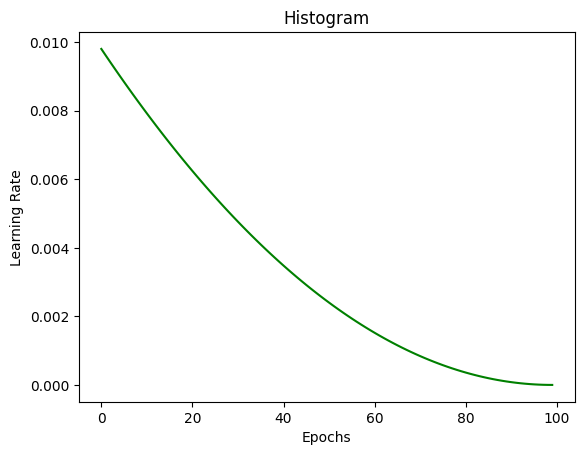

In [53]:
plt.plot(learning_rates, color = 'green')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate');

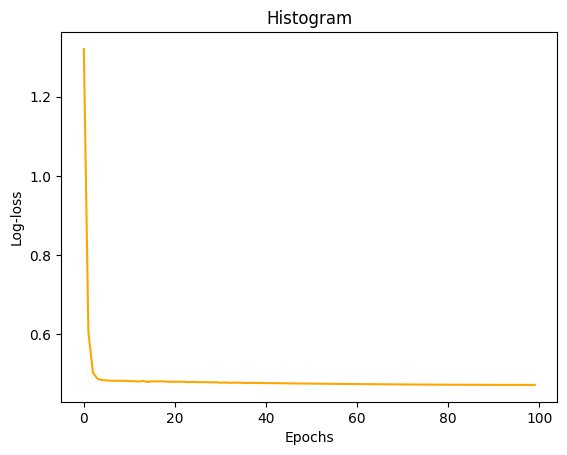

In [54]:
plt.plot(loss_epochs, color = 'orange')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

We observe that optimizing the loss, one observation at a time, can be quite slow. Hence, let us consider *mini-batches* of data instead. All we need to do is change the *batch_size* parameter in *DataLoader*.

In [55]:
torch.manual_seed(123)

log_reg_nn.apply(init_weights) # reset the weights of the NN

n_epochs = 200

loss_epochs = np.zeros(n_epochs) 
learning_rates = np.zeros(n_epochs)

heart_loader = DataLoader(dataset = heart_pytorch_dataset, batch_size = 50, shuffle = True) 
optim_SGD =  torch.optim.SGD(log_reg_nn.parameters(), lr = 1e-2)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optim_SGD, total_iters= n_epochs, power = 2)


start = time.time()
for t in range(n_epochs):
    loss_epochs[t], learning_rates[t] = train_loop2(heart_loader, log_reg_nn, logistic_loss, optim_SGD, scheduler)
end = time.time()
print(end - start)   

2.7782576084136963


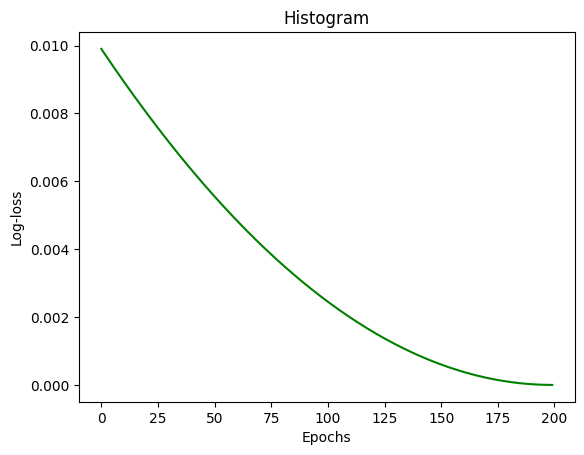

In [56]:
plt.plot(learning_rates, color = 'green')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

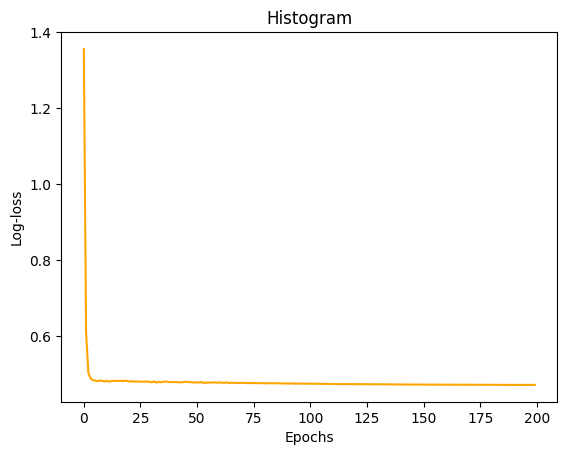

In [57]:
plt.plot(loss_epochs, color = 'orange')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

In [58]:
loss_epochs.min()

0.472186803817749

In [59]:
roc_auc_score(obs_heart, log_reg_nn(X).detach())

0.8517812560015363

We observe that with mini-batches, we evaluated 100 epochs much faster. We can also notice that we successfully recovered the optimal model.

## Multilayer Perceptron <a class="anchor" id="multi-perceptron"></a>

A multilayer perceptron is the simplest feedforward neural network that is deep (i.e., with at least one hidden layer). In a multilayer perceptron neural network, all neurons are fully connected.  Since we combine neurons in multiple layers, the resulting classifier is no longer linear. The main hyperparameters  to explore for a multilayer perceptron are the number of hidden layers, the number of neurons in the hidden layers, and the activation functions.

### Activation Functions <a class="anchor" id="activf"></a>
Regarding the activation function, we already know the sigmoid function.

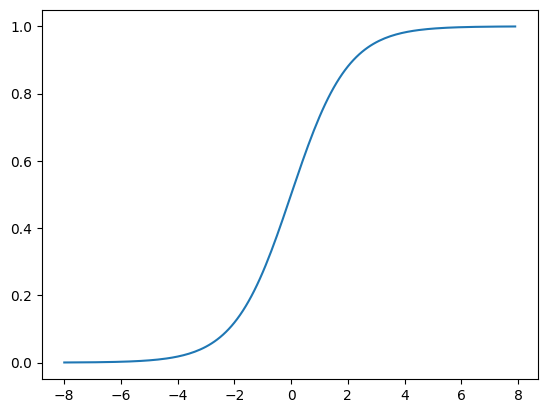

In [60]:
x_sigm = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y_sigm = torch.sigmoid(x_sigm)
plt.plot(x_sigm.detach(), y_sigm.detach());

The sigmoid function was excellent at turning real outputs into probability estimates, making it ideal for an output layer for binary classification problems. It is also a smooth function. However, as far as an activation function in hidden layers is concerned, there is an issue with its derivative.

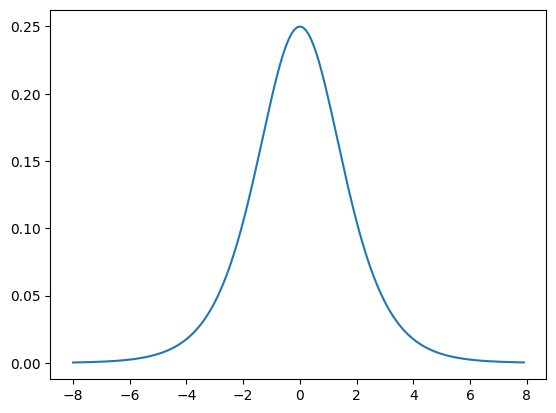

In [61]:
y_sigm.backward(torch.ones_like(x_sigm),retain_graph=True)
plt.plot(x_sigm.detach(),  x_sigm.grad.detach());

We can see that the derivative is always less than one-fourth and vanishes at both large positive and negative inputs. Consequently, when we consider a deep neural network with multiple hidden layers with the sigmoid activation function, the gradients of the parameters for earlier layers can be very small and may even approach zero. This fact will make it very difficult to train these earlier layers via gradient descent. This issue is known as the *vanishing gradient problem*, and it is one of the major difficulties that must be addressed when dealing with deep neural networks [[4](#4)].

A simple remedy in terms of activation functions is to use the *rectified linear unit* activation (ReLU) function in hidden layers instead [[4](#4)].

$$ \text{ReLU}(x) = \frac{x + |x|}{2}$$

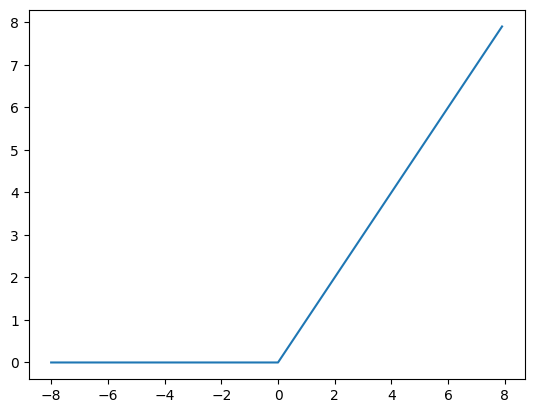

In [62]:
x_relu = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y_relu = torch.relu(x_relu)
plt.plot(x_relu.detach(), y_relu.detach());

The gradient of ReLU is very simple and mostly avoids vanishing gradients (altough, a neuron can still get stuck if the weighted sum of inputs are almost always negative).

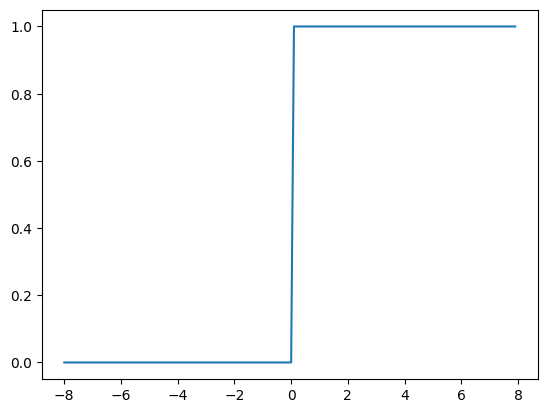

In [63]:
y_relu.backward(torch.ones_like(x_relu),retain_graph=True)
plt.plot(x_relu.detach(),  x_relu.grad.detach());

Let us implement a simple multilayer perceptron with one hidden layer.

In [64]:
class Multi_Perceptron_Net_1h(nn.Module):
    def __init__(self, input_size, n_hidden):
        super().__init__()
        self.log_reg_stack = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1),    
            nn.Sigmoid()
        )
    
    def forward(self, x):
        output = self.log_reg_stack(x)
        return output

In [65]:
multi_percp_1hidden_10 = Multi_Perceptron_Net_1h(17,10)
print(multi_percp_1hidden_10)

Multi_Perceptron_Net_1h(
  (log_reg_stack): Sequential(
    (0): Linear(in_features=17, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


### Weights Initialization  <a class="anchor" id="weights"></a>

When dealing with deep neural networks, we must be more careful with initializing the weights, because it can be quite easy to produce outputs (or their gradients) that will explode in value.

In [66]:
torch.manual_seed(123)
multi_percp_1hidden_10.apply(init_weights)
logistic_loss(y, multi_percp_1hidden_10(X)) 

tensor(nan, grad_fn=<SumBackward0>)

We observe that even in our quite simple example, our original $N(0,1)$ initialization is causing some problems since it produces NaN loss. Thus, we will investigate more sophisticated initialization methods. The Xavier uniform distribution (Glorot initialization) [[8](#8)] is an uniform random initialization on $[-r, r]$, where  
$$r = \sqrt{\frac{6}{\text{fan-in} + \text{fan-out}}}$$
Fan-in is the number of input signals into the layer, and fan-out is the number of output signals from the layer. The initialization is derived (for the linear regime, when the activation function meets $f(z) \approx z$) as a compromise between keeping constant the variance of the outputs of the layers $\text{Var } z_i = \text{Var } z_j$ for all $i,j$, where  $z_{i+1} = f(w^T z_i + b_i) = f(s_i)$ during the forward pass and keping constant the varinace of gradients in the backward pass  $\text{Var } \frac{\partial \text{Cost}}{\partial s_i} = \text{Var }  \frac{\partial \text{Cost}}{\partial s_j} $  for all $i,j$ [[8](#8)].

Provided that we want to generate weights using normal distribution with the same variance, we get  $$\sigma^2 = \frac{2}{(\text{fan-in} + \text{fan-out})}$$ since the variance of the uniform distribution on $[-r, r]$ is $r^2/3$.

In [67]:
def init_weights_xavier(model):
    if isinstance(model, nn.Linear):
        nn.init.xavier_uniform_(model.weight, gain = 1.0) 
        nn.init.constant_(model.bias, 0)       

In [68]:
torch.manual_seed(123)
multi_percp_1hidden_10.apply(init_weights_xavier)
logistic_loss(y, multi_percp_1hidden_10(X)) 

tensor(881.6971, grad_fn=<SumBackward0>)

Alternatively, we can consider He initialization [[9](#9)], which is specifically designed for ReLU (ReLU does not behave linearly). Using the similar derivations as in [[8](#8)], the authors of [[9](#9)] derived the initialization $N(0,\sigma^2)$, where 
$$\sigma^2 = \frac{2}{\text{fan-in}},$$
which leads to the so-called Kaiming uniform distribution
$$r = \sqrt{\frac{6}{\text{fan-in}}}.$$

In [69]:
def init_weights_he(model):
    if isinstance(model, nn.Linear):
        nn.init.kaiming_normal_(model.weight, nonlinearity = 'relu') 
        nn.init.constant_(model.bias, 0)       

In [70]:
torch.manual_seed(123)
multi_percp_1hidden_10.apply(init_weights_he)
logistic_loss(y, multi_percp_1hidden_10(X)) 

tensor(704.6202, grad_fn=<SumBackward0>)

### Training Deep Neural Networks  <a class="anchor" id="training"></a>

Having successfully initialized the multilayer perceptron, let us now train the neural network. We will now go through several techniques to improve the performance of training using SGD or mini-batch gradient descent (MBGD). Let us start with the default MBGD with a batch size 50.

In [71]:
n_epochs = 1000

loss_epochs = np.zeros(n_epochs) 
learning_rates = np.zeros(n_epochs)

heart_loader = DataLoader(dataset = heart_pytorch_dataset, batch_size = 50, shuffle = True) 
optim_SGD =  torch.optim.SGD(multi_percp_1hidden_10.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optim_SGD, total_iters = n_epochs, power = 2)

start = time.time()
for t in range(n_epochs):
    loss_epochs[t], learning_rates[t] = train_loop2(heart_loader, multi_percp_1hidden_10, logistic_loss, optim_SGD, scheduler)
end = time.time()
print(end - start)

17.927281141281128


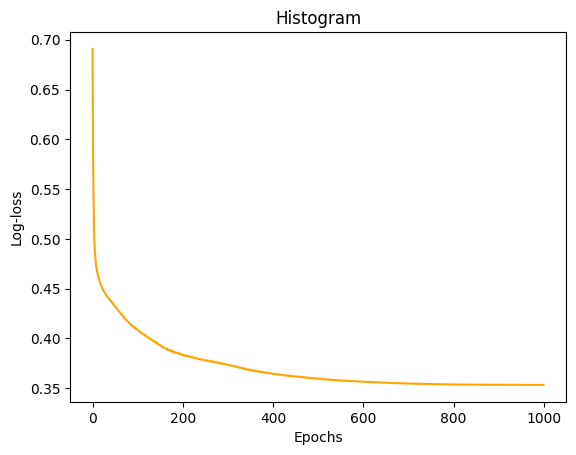

In [72]:
plt.plot(loss_epochs, color = 'orange')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

#### Momentum <a class="anchor" id="momentum"></a>

We can attempt to increase the convergence speed of MBGD by introducing *momentum*; instead of using mini-batch gradients $g_t = \frac{1}{n_B}\nabla_w \sum_{i = 1}^{n_B} f(x_i;w_{i-1})$ directly for the update, MBGD with momentum uses "leaky" average gradient $v_t = g_t + \lambda v_{t-1}$, where $v_t = g_t + \lambda g_{t-2} + \lambda^2  g_{t-3} \cdots$ is called *velocity*. Consequently, the updates no longer point in the direction of the steepest descent (wrt. a given mini-batch) but rather in the direction
of a weighted average of past gradients [[4](#4)]. Not only momentum stabilizes the descent directions, it can be show to be more effective for ill-conditioned problems (see https://distill.pub/2017/momentum/?utm_campaign=Artificial%2BIntelligence%2BWeekly&utm_medium=email&utm_source=Artificial_Intelligence_Weekly_59 for more details)

In *PyTorch*, we can select the momentum parameter $\lambda$ using the *momentum* parameter.

In [73]:
torch.manual_seed(123)
multi_percp_1hidden_10.apply(init_weights_he)

n_epochs = 1000

loss_epochs = np.zeros(n_epochs) 
learning_rates = np.zeros(n_epochs)

heart_loader = DataLoader(dataset = heart_pytorch_dataset, batch_size = 50, shuffle = True) 
optim_SGD =  torch.optim.SGD(multi_percp_1hidden_10.parameters(), lr = 0.001, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optim_SGD, total_iters = n_epochs, power = 2)

start = time.time()
for t in range(n_epochs):
    loss_epochs[t], learning_rates[t] = train_loop2(heart_loader, multi_percp_1hidden_10, logistic_loss, optim_SGD, scheduler)
end = time.time()
print(end - start)

17.80804467201233


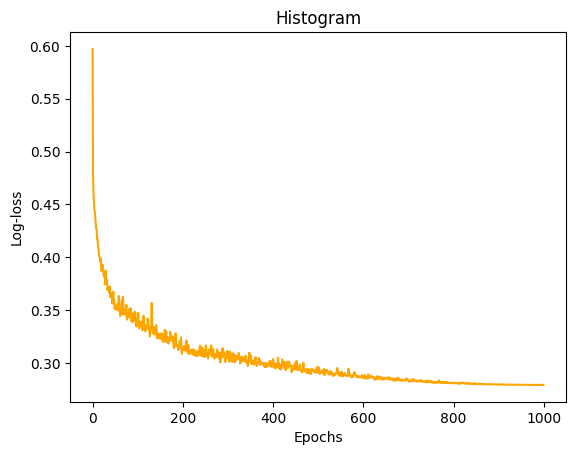

In [74]:
plt.plot(loss_epochs, color = 'orange')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

We observe that the algorithm converged to a significantly lower value of the loss function with the same number of iterations and using the same learning rate.

Overall, we converged to a model with a much lower training loss than our linear logistic regression model.

In [75]:
log_loss(y, multi_percp_1hidden_10(X).detach())

0.27916723693155565

In [76]:
brier_score_loss(y, multi_percp_1hidden_10(X).detach())

0.08699283079055115

In [77]:
roc_auc_score(y, multi_percp_1hidden_10(X).detach())

0.9504609179950068

However, a multilayer perceptron has many more parameters than logistic regression (the hidden layer of our model has 10 neurons with 180 parameters). Thus, we must ensure that reducing the training loss also reduces the classification loss on new data. 

#### Evaluating Test Set Performance <a class="anchor" id="test"></a>

Let us split our dataset into training and test datasets.

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(heart_final.iloc[:,range(0,17)], heart_final['heart_disease'], test_size= 0.1, random_state = 123)

scaler_train = StandardScaler().fit(X = X_train)
heart_train_final_scaled = pd.DataFrame(scaler_train.transform(X_train))
heart_test_final_scaled = pd.DataFrame(scaler_train.transform(X_test))

X_train = torch.from_numpy(heart_train_final_scaled.values).type(torch.float)
X_test = torch.from_numpy(heart_test_final_scaled.values).type(torch.float)
y_train = torch.from_numpy(y_train.values).type(torch.LongTensor)
y_test = torch.from_numpy(y_test.values).type(torch.LongTensor)

heart_pytorch_dataset_train = TensorDataset(X_train, y_train)

We modify our training loop to also include performance evaluation on the test set. 

In [79]:
def train_test_loop(dataloader, X_test, y_test, model, loss_fn, optimizer, scheduler):
    size = len(dataloader.dataset)
    model.train()

    loss_sum_train  = 0
    
    for batch, (X, y) in enumerate(dataloader):
        
        pred_y = model(X) # forward pass
        loss = loss_fn(y, pred_y) # loss evaluation 

        # Backpropagation
        loss.backward() # gradient evaluation
        optimizer.step() # SGD step
        optimizer.zero_grad() # zero out the gradients

        loss_sum_train = loss_sum_train + loss 
    
    scheduler.step() # learning rate step
    learning_rate = scheduler.get_last_lr() 

    with torch.no_grad(): # we do not need to compute the gradients
        model.eval() # some elements of neural networks behave differently outside of training; see dropout and batch normalization
        loss_test = logistic_loss(y_test, model(X_test))/len(X_test)

    return  loss_sum_train.detach()/size, loss_test.detach(), learning_rate[0]

Let us train our model again and, in addition, record the performance on the test set.

In [80]:
torch.manual_seed(123)

multi_percp_1hidden_10.apply(init_weights_he) 

n_epochs = 1000

loss_epochs_train = np.zeros(n_epochs) 
loss_epochs_test = np.zeros(n_epochs) 
learning_rates = np.zeros(n_epochs)

heart_loader_train = DataLoader(dataset = heart_pytorch_dataset_train, batch_size = 50, shuffle = True) 
optim_SGD =  torch.optim.SGD(multi_percp_1hidden_10.parameters(), lr = 0.001, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optim_SGD, total_iters= n_epochs, power = 2)

start = time.time()
for t in range(n_epochs):
    loss_epochs_train[t], loss_epochs_test[t], learning_rates[t] = train_test_loop(heart_loader_train, X_test, y_test, multi_percp_1hidden_10, logistic_loss, optim_SGD, scheduler)
end = time.time()
print(end - start)

16.35074782371521


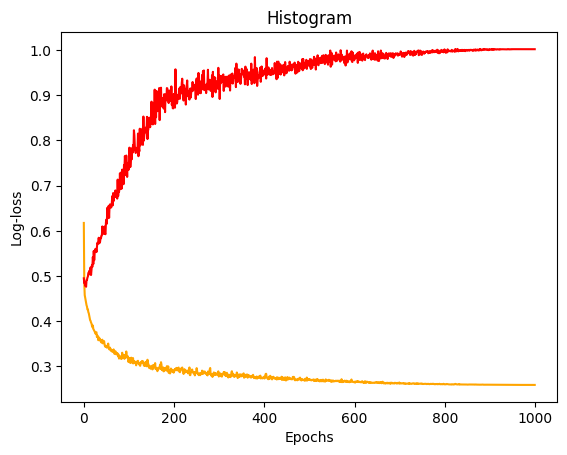

In [81]:
plt.plot(loss_epochs_train, color = 'orange')
plt.plot(loss_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

In [82]:
brier_score_loss(y_test.detach(), multi_percp_1hidden_10(X_test).detach())

0.22006550430336838

In [83]:
roc_auc_score(y_test.detach(), multi_percp_1hidden_10(X_test).detach())

0.7836174242424243

We observe that while the training loss decreased, the test loss worsened, indicating that our model does not generalize well to new data. In contrast, logistic regression usually generalizes quite well.

In [84]:
torch.manual_seed(123)
log_reg_nn.apply(init_weights) 

n_epochs = 150

loss_epochs_train = np.zeros(n_epochs) 
loss_epochs_test = np.zeros(n_epochs) 
learning_rates = np.zeros(n_epochs)

heart_loader_train = DataLoader(dataset = heart_pytorch_dataset_train, batch_size = 50, shuffle = True) 
optim_SGD =  torch.optim.SGD(log_reg_nn.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optim_SGD, total_iters= n_epochs, power = 2)

start = time.time()
for t in range(n_epochs):
    loss_epochs_train[t], loss_epochs_test[t], learning_rates[t] = train_test_loop(heart_loader_train, X_test, y_test, log_reg_nn, logistic_loss, optim_SGD, scheduler)
end = time.time()
print(end - start)

1.9317452907562256


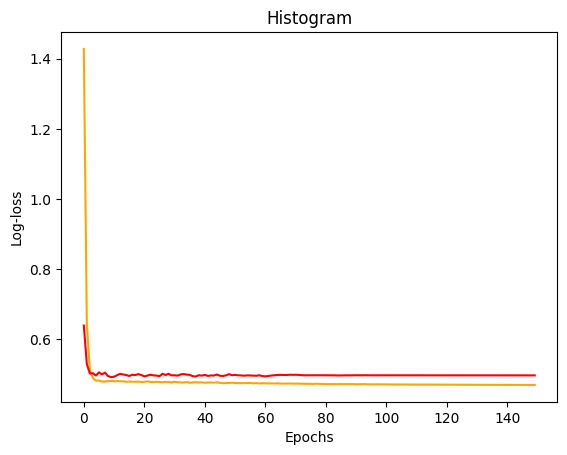

In [85]:
plt.plot(loss_epochs_train, color = 'orange')
plt.plot(loss_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

In [86]:
log_loss(y_test.detach(), log_reg_nn(X_test).detach())

0.4975894392644784

In [87]:
brier_score_loss(y_test.detach(), log_reg_nn(X_test).detach())

0.1539432461820516

In [88]:
roc_auc_score(y_test.detach(), log_reg_nn(X_test).detach())

0.8418560606060606

A straightforward way to improve the generalizability of complex models is to use regularization techniques during training. Let us explore some common approaches.

#### Weight Decay (L2 Regularization) <a class="anchor" id="l2"></a>

The first quite universal approach we already encountered is the addition of an L2-penalty term into the loss function, i.e., ridge regression. In the context of deep learning, this technique is known as *weight decay*. This term is used because, given the penalty term alone, optimizing the L2 penalty results in weight decay at each training step [[4](#4)].

In *PyTorch*, *weight_decay* is the parameter of the optimization algorithm, in our case *torch.optim.SGD*.

In [89]:
torch.manual_seed(123)

multi_percp_1hidden_10.apply(init_weights_he) 

n_epochs = 1000

loss_epochs_train = np.zeros(n_epochs) 
loss_epochs_test = np.zeros(n_epochs) 
learning_rates = np.zeros(n_epochs)

heart_loader_train = DataLoader(dataset = heart_pytorch_dataset_train, batch_size = 50, shuffle = True) 
optim_SGD =  torch.optim.SGD(multi_percp_1hidden_10.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 3)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optim_SGD, total_iters= n_epochs, power = 2)

start = time.time()
for t in range(n_epochs):
    loss_epochs_train[t], loss_epochs_test[t], learning_rates[t] = train_test_loop(heart_loader_train, X_test, y_test, multi_percp_1hidden_10, logistic_loss, optim_SGD, scheduler)
end = time.time()
print(end - start)

15.693495035171509


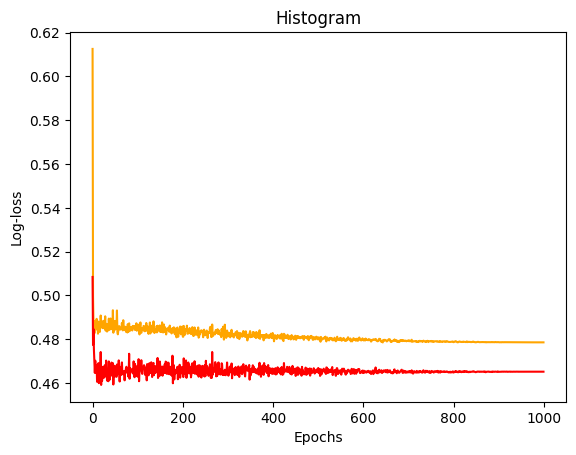

In [90]:
plt.plot(loss_epochs_train, color = 'orange')
plt.plot(loss_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

In [91]:
log_loss(y_test.detach(), multi_percp_1hidden_10(X_test).detach())

0.4651541224213563

In [92]:
brier_score_loss(y_test.detach(), multi_percp_1hidden_10(X_test).detach())

0.14575215722676038

In [93]:
roc_auc_score(y_test.detach(), multi_percp_1hidden_10(X_test).detach())

0.8589015151515151

We observe that L2 regularization significantly improved generalizability, and we have obtained a model that performs slightly better on the test dataset than logistic regression. The calibration on the test dataset is as follows.

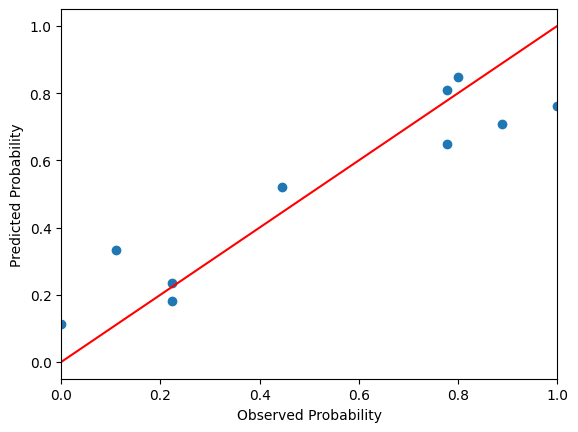

In [94]:
prob_true_percp_1hidden_10, prob_pred_qda_percp_1hidden_10 = calibration_curve(y_test.detach(), multi_percp_1hidden_10(X_test).detach(), n_bins=10, strategy = 'quantile')
sm.graphics.abline_plot(intercept = 0,slope = 1,color = 'red')
plt.scatter(prob_true_percp_1hidden_10,prob_pred_qda_percp_1hidden_10)
plt.xlabel('Observed Probability')
plt.ylabel('Predicted Probability');

#### L1 Regularization <a class="anchor" id="l1"></a>

We can also use the L1 regularization. The L1 penalty is not directly implemented in *PyTorch*, hence we have to implement it ourselves.

In [95]:
def train_test_loop_withL1(dataloader, X_test, y_test, model, loss_fn, optimizer, scheduler, lambda_l1):
    size = len(dataloader.dataset)
    model.train()

    loss_sum_train  = 0
    
    for batch, (X, y) in enumerate(dataloader):
        
        pred_y = model(X) # forward pass
        loss = loss_fn(y, pred_y) # loss evaluation 

        # L1 penalty
        l1_penalty = 0
        for param in model.parameters():
            if param.dim() > 1: # do not penalize biases
                l1_penalty += torch.sum(torch.abs(param))
        loss = loss + l1_penalty*lambda_l1
        
        # Backpropagation
        loss.backward() # gradient evaluation
        optimizer.step() # SGD step
        optimizer.zero_grad() # zero out the gradients

        loss_sum_train = loss_sum_train + loss 
    
    scheduler.step() # learning rate step
    learning_rate = scheduler.get_last_lr() 

    with torch.no_grad(): # we do not need to compute the gradients
        model.eval() # some elements of neural networks behave differently outside of training; see dropout and batch normalization
        loss_test = logistic_loss(y_test, model(X_test))/len(X_test)

    return  loss_sum_train.detach()/size, loss_test.detach(), learning_rate[0]

In [96]:
torch.manual_seed(123)

multi_percp_1hidden_10.apply(init_weights_he) 

n_epochs = 1000

loss_epochs_train = np.zeros(n_epochs) 
loss_epochs_test = np.zeros(n_epochs) 
learning_rates = np.zeros(n_epochs)

heart_loader_train = DataLoader(dataset = heart_pytorch_dataset_train, batch_size = 50, shuffle = True) 
optim_SGD =  torch.optim.SGD(multi_percp_1hidden_10.parameters(), lr = 0.001, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optim_SGD, total_iters= n_epochs, power = 2)

start = time.time()
for t in range(n_epochs):
    loss_epochs_train[t], loss_epochs_test[t], learning_rates[t] = train_test_loop_withL1(heart_loader_train, X_test, y_test, multi_percp_1hidden_10, logistic_loss, optim_SGD, scheduler, 0.5)
end = time.time()
print(end - start)

17.790831804275513


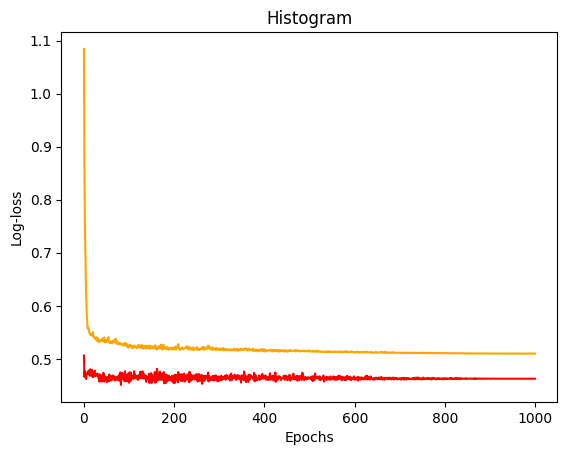

In [97]:
plt.plot(loss_epochs_train, color = 'orange')
plt.plot(loss_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

In [98]:
log_loss(y_test.detach(), multi_percp_1hidden_10(X_test).detach())

0.4625973686081039

In [99]:
brier_score_loss(y_test.detach(), multi_percp_1hidden_10(X_test).detach())

0.1444184486381222

In [100]:
roc_auc_score(y_test.detach(), multi_percp_1hidden_10(X_test).detach())

0.852035984848485

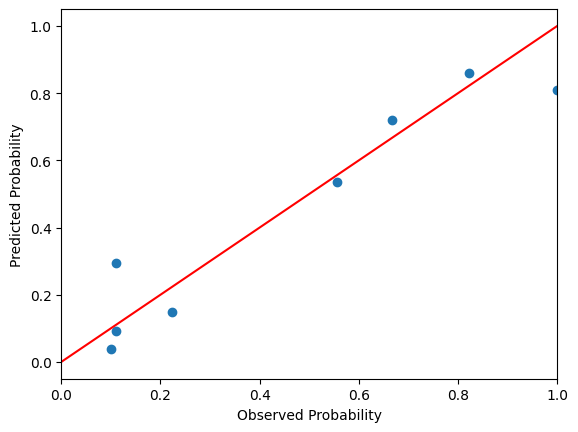

In [101]:
prob_true_percp_1hidden_10, prob_pred_qda_percp_1hidden_10 = calibration_curve(y_test.detach(), multi_percp_1hidden_10(X_test).detach(), n_bins=10, strategy = 'quantile')
sm.graphics.abline_plot(intercept = 0,slope = 1,color = 'red')
plt.scatter(prob_true_percp_1hidden_10,prob_pred_qda_percp_1hidden_10)
plt.xlabel('Observed Probability')
plt.ylabel('Predicted Probability');

We observe that we can regularize the neural network with an L1 penalty as well.

#### Dropout <a class="anchor" id="dropout"></a>

Another regularization strategy more specific to neural networks is *dropout* [[10](#10)]. When training the neural network with dropout, some randomly chosen neurons are "dropped out" (their outputs are zeroed out) from the network during each training iteration. The outputs of the neurons of the remaining neurons in the layer where dropout is employed are rescaled by dropout probability (i.e., the output of the neuron is $h'(x) = h(x^Tw)/(1-p)$, where $p$ is dropout probability). Consequently, the expected outputs of the neurons stay equal to $h(x^Tw)$. 

Standard neural network training learns brittle connections that do not generalize well to unseen data. Dropout aims to break up these connections. From the theoretical standpoint, it can be shown that dropout is equivalent to ridge regression for the linear regression model [[10](#10)]. 

In *PyTorch,* we can simply include dropout by adding a *nn.Dropout* layer to the network.

In [102]:
class Multi_Perceptron_Net_1h_dropout(nn.Module):
    def __init__(self, input_size, n_hidden, p_dropout):
        super().__init__()
        self.log_reg_stack = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, 1),    
            nn.Sigmoid()
        )
    
    def forward(self, x):
        output = self.log_reg_stack(x)
        return output

In [103]:
multi_percp_1hidden_10_dropout = Multi_Perceptron_Net_1h_dropout(17,10,0.5)
print(multi_percp_1hidden_10_dropout)

Multi_Perceptron_Net_1h_dropout(
  (log_reg_stack): Sequential(
    (0): Linear(in_features=17, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=10, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


In [104]:
torch.manual_seed(123)

multi_percp_1hidden_10_dropout.apply(init_weights_he) 

n_epochs = 1000

loss_epochs_train = np.zeros(n_epochs) 
loss_epochs_test = np.zeros(n_epochs) 
learning_rates = np.zeros(n_epochs)

heart_loader_train = DataLoader(dataset = heart_pytorch_dataset_train, batch_size = 50, shuffle = True) 
optim_SGD =  torch.optim.SGD(multi_percp_1hidden_10_dropout.parameters(), lr = 0.0001, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optim_SGD, total_iters = n_epochs, power = 2)

start = time.time()
for t in range(n_epochs):
    loss_epochs_train[t], loss_epochs_test[t], learning_rates[t] = train_test_loop(heart_loader_train, X_test, y_test, multi_percp_1hidden_10_dropout, logistic_loss, optim_SGD, scheduler)
end = time.time()
print(end - start)

17.524292707443237


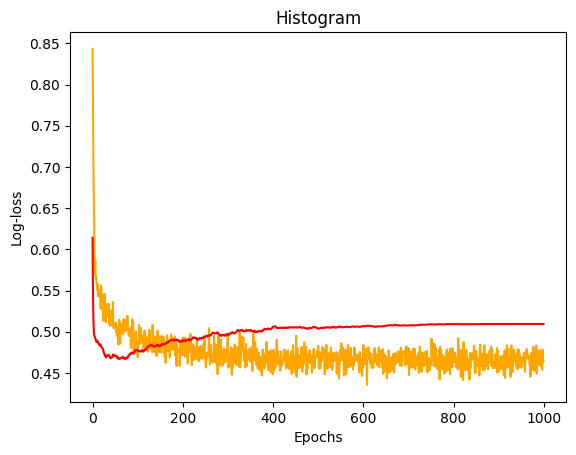

In [105]:
plt.plot(loss_epochs_train, color = 'orange')
plt.plot(loss_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

We should note that dropout should be used only during training. When evaluating the model's predictions, dropout is ignored. To let *PyTorch* know, that we are evaluating the model and not training we use  *model.eval()* instead of *model.train()*.

In [108]:
multi_percp_1hidden_10_dropout.eval()
multi_percp_1hidden_10_dropout.training

False

In [109]:

log_loss(y_test.detach(), multi_percp_1hidden_10_dropout(X_test).detach())

0.509417276677661

In [110]:
brier_score_loss(y_test.detach(), multi_percp_1hidden_10_dropout(X_test).detach())

0.153616203178551

In [111]:
roc_auc_score(y_test.detach(), multi_percp_1hidden_10_dropout(X_test).detach())

0.8399621212121213

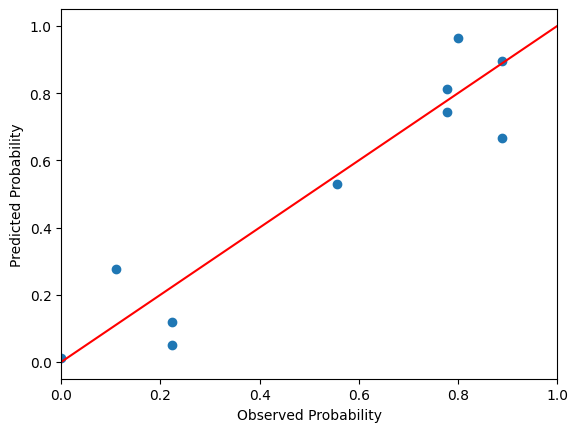

In [112]:
prob_true_percp_1hidden_10, prob_pred_qda_percp_1hidden_10 = calibration_curve(y_test.detach(), multi_percp_1hidden_10_dropout(X_test).detach(), n_bins=10, strategy = 'quantile')
sm.graphics.abline_plot(intercept = 0,slope = 1,color = 'red')
plt.scatter(prob_true_percp_1hidden_10,prob_pred_qda_percp_1hidden_10)
plt.xlabel('Observed Probability')
plt.ylabel('Predicted Probability');

Naturally, we can also combine dropout with other regularization approaches, such as weight decay.

In [113]:
torch.manual_seed(123)

multi_percp_1hidden_10_dropout.apply(init_weights_he) 

n_epochs = 1000

loss_epochs_train = np.zeros(n_epochs) 
loss_epochs_test = np.zeros(n_epochs) 
learning_rates = np.zeros(n_epochs)

heart_loader_train = DataLoader(dataset = heart_pytorch_dataset_train, batch_size = 50, shuffle = True) 
optim_SGD =  torch.optim.SGD(multi_percp_1hidden_10_dropout.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 3)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optim_SGD, total_iters = n_epochs, power = 2)

start = time.time()
for t in range(n_epochs):
    loss_epochs_train[t], loss_epochs_test[t], learning_rates[t] = train_test_loop(heart_loader_train, X_test, y_test, multi_percp_1hidden_10_dropout, logistic_loss, optim_SGD, scheduler)
end = time.time()
print(end - start)

15.986635208129883


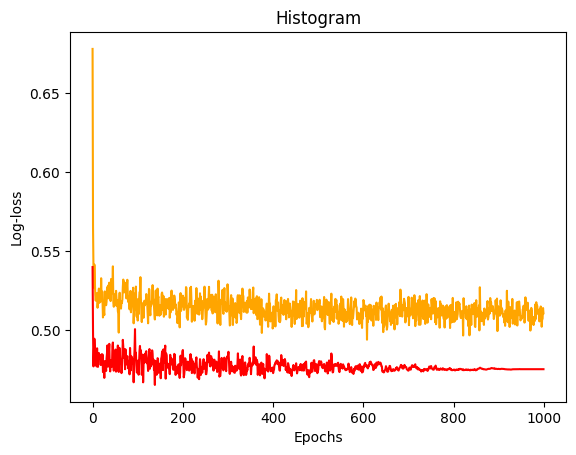

In [114]:
plt.plot(loss_epochs_train, color = 'orange')
plt.plot(loss_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

In [115]:
multi_percp_1hidden_10_dropout.eval()
log_loss(y_test.detach(), multi_percp_1hidden_10_dropout(X_test).detach())

0.47539739820725346

In [116]:
brier_score_loss(y_test.detach(), multi_percp_1hidden_10_dropout(X_test).detach())

0.14955650504862772

In [117]:
roc_auc_score(y_test.detach(), multi_percp_1hidden_10_dropout(X_test).detach())

0.8584280303030303

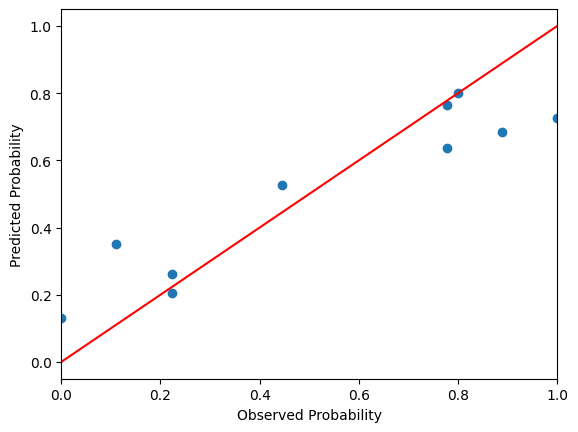

In [118]:
prob_true_percp_1hidden_10, prob_pred_qda_percp_1hidden_10 = calibration_curve(y_test.detach(), multi_percp_1hidden_10_dropout(X_test).detach(), n_bins=10, strategy = 'quantile')
sm.graphics.abline_plot(intercept = 0,slope = 1,color = 'red')
plt.scatter(prob_true_percp_1hidden_10,prob_pred_qda_percp_1hidden_10)
plt.xlabel('Observed Probability')
plt.ylabel('Predicted Probability');

#### Gradient Clipping <a class="anchor" id="grad_clipping"></a>

Let us now consider a deeper neural network with three hidden layers.

In [120]:
class Multi_Perceptron_Net_deep(nn.Module):
    def __init__(self, input_size, n_hidden):
        super().__init__()
        self.log_reg_stack = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1),    
            nn.Sigmoid()
        )
    
    def forward(self, x):
        output = self.log_reg_stack(x)
        return output

For complex neural networks, it is much easier for gradiends to "blow-up" (gradints grow extremely large, they so-called *exploding hradients* [[4](#4)]).

In [121]:
multi_percp_3deep_10 = Multi_Perceptron_Net_deep(17,10)

In [122]:
torch.manual_seed(123)

multi_percp_3deep_10.apply(init_weights_he) 

n_epochs = 100

loss_epochs_train = np.zeros(n_epochs) 
loss_epochs_test = np.zeros(n_epochs) 
learning_rates = np.zeros(n_epochs)

heart_loader_train = DataLoader(dataset = heart_pytorch_dataset_train, batch_size = 50, shuffle = True) 
optim_SGD =  torch.optim.SGD(multi_percp_3deep_10.parameters(), lr = 0.001, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optim_SGD, total_iters = n_epochs, power = 2)

start = time.time()
for t in range(n_epochs):
    loss_epochs_train[t], loss_epochs_test[t], learning_rates[t] = train_test_loop(heart_loader_train, X_test, y_test, multi_percp_3deep_10, logistic_loss, optim_SGD, scheduler)
end = time.time()
print(end - start)

2.3296000957489014


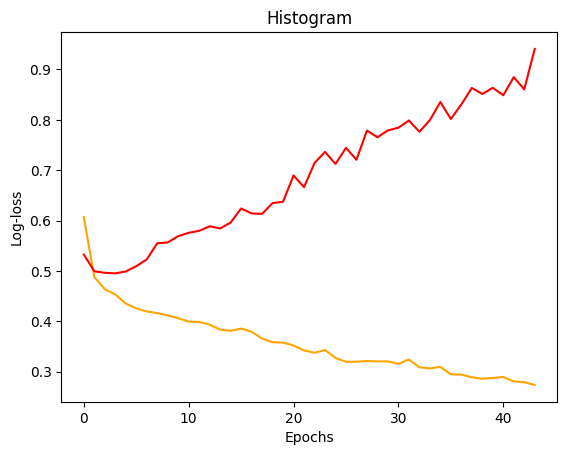

In [123]:
plt.plot(loss_epochs_train, color = 'orange')
plt.plot(loss_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

We observe that training stopped quite fast. One solution would be to decrease the learning rate.

In [124]:
torch.manual_seed(123)

multi_percp_3deep_10.apply(init_weights_he) 

n_epochs = 100

loss_epochs_train = np.zeros(n_epochs) 
loss_epochs_test = np.zeros(n_epochs) 
learning_rates = np.zeros(n_epochs)

heart_loader_train = DataLoader(dataset = heart_pytorch_dataset_train, batch_size = 50, shuffle = True) 
optim_SGD =  torch.optim.SGD(multi_percp_3deep_10.parameters(), lr = 0.0001, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optim_SGD, total_iters = n_epochs, power = 2)

start = time.time()
for t in range(n_epochs):
    loss_epochs_train[t], loss_epochs_test[t], learning_rates[t] = train_test_loop(heart_loader_train, X_test, y_test, multi_percp_3deep_10, logistic_loss, optim_SGD, scheduler)
end = time.time()
print(end - start)

2.268768787384033


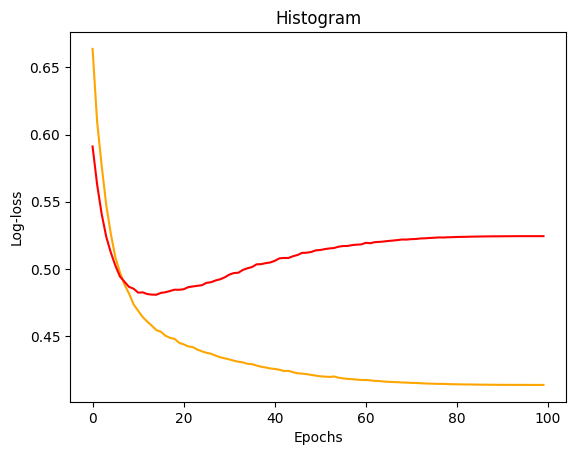

In [125]:
plt.plot(loss_epochs_train, color = 'orange')
plt.plot(loss_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

However, since we do not want to be required to precisely tune the learning rate for every problem, we will use *gradient clipping* during training [[10](#10)]. We will simply restrict the value of the gradient to a specified value. Specifically, *torch.nn.utils.clip_grad_norm_* normalizes the overall gradient whenever it exceeds a given threshold. 

In [127]:
def train_test_loop_clipping(dataloader, X_test, y_test, model, loss_fn, optimizer, scheduler, clipping):
    size = len(dataloader.dataset)
    model.train()

    loss_sum_train  = 0
    
    for batch, (X, y) in enumerate(dataloader):
        
        pred_y = model(X) # forward pass
        loss = loss_fn(y, pred_y) # loss evaluation 

        # Backpropagation
        loss.backward() # gradient evaluation
        torch.nn.utils.clip_grad_norm_(model.parameters(), clipping) # gradient clipping 
        optimizer.step() # SGD step
        optimizer.zero_grad() # zero out the gradients

        loss_sum_train = loss_sum_train + loss 
    
    scheduler.step() # learning rate step
    learning_rate = scheduler.get_last_lr() 

    with torch.no_grad(): # we do not need to compute the gradients
        model.eval() # some elements of neural networks behave differently outside of training; see dropout and batch normalization
        loss_test = logistic_loss(y_test, model(X_test))/len(X_test)

    return  loss_sum_train.detach()/size, loss_test.detach(), learning_rate[0]

In [128]:
torch.manual_seed(123)

multi_percp_3deep_10.apply(init_weights_he) 

n_epochs = 10000

loss_epochs_train = np.zeros(n_epochs) 
loss_epochs_test = np.zeros(n_epochs) 
learning_rates = np.zeros(n_epochs)

heart_loader_train = DataLoader(dataset = heart_pytorch_dataset_train, batch_size = 50, shuffle = True) 
optim_SGD =  torch.optim.SGD(multi_percp_3deep_10.parameters(), lr = 0.001, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optim_SGD, total_iters = n_epochs, power = 2)

start = time.time()
for t in range(n_epochs):
    loss_epochs_train[t], loss_epochs_test[t], learning_rates[t] = train_test_loop_clipping(heart_loader_train, X_test, y_test, multi_percp_3deep_10, logistic_loss, optim_SGD, scheduler, 0.1)
end = time.time()
print(end - start)

229.8204324245453


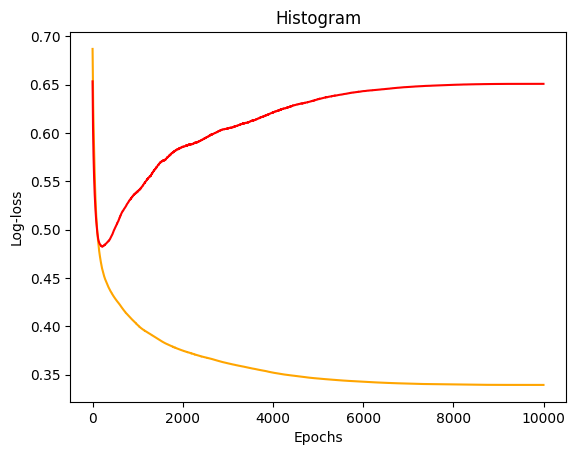

In [130]:
plt.plot(loss_epochs_train, color = 'orange')
plt.plot(loss_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

We observe that with gradient clipping,  training progressed successfully even for the larger value of the training rate.

#### Batch Normalization <a class="anchor" id="batch_norm"></a> 

The last learning technique we will describe in this introductory project on neural networks is batch normalization, which has been empirically shown to significantly aid the training of deep neural networks [[4](#4), [11](#11)]. As the name would suggest, batch normalization normalizes the internal inputs/outputs between layers. It was demonstrated that this smoothens both the loss and the gradient, increasing the speed of convergence of MBGD [[12](#12)].

The batch normalization for a signal $x$ is given as follows [[4](#4)]
$$ y = \gamma\frac{x - \mathrm{E}x}{\sqrt{\text{Var }x + \varepsilon}} +  \beta,$$
where $\varepsilon$ is a small constant (e.g., $\varepsilon = 10^{-5}$),  $\gamma$ and $\beta$ are parameters learned during the training from the data, and $\mathrm{E}x$ and $\text{Var }x$ are estimated from the current batch of the data. We should note that *PyTorch* learns running estimates of the mean and variance to predict outputs for new observations. The batch normalization is usually put betwen the linear layer and the activation function [[4](#4)]
$$ y = h(w^Tx) \rightarrow y = h(\text{BN}(w^Tx)).$$



In [131]:
class Multi_Perceptron_Net_deep_bn(nn.Module):
    def __init__(self, input_size, n_hidden):
        super().__init__()
        self.log_reg_stack = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1), 
            nn.BatchNorm1d(1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        output = self.log_reg_stack(x)
        return output

In [132]:
multi_percp_3deep_10_bn = Multi_Perceptron_Net_deep_bn(17,10)

In [133]:
torch.manual_seed(123)

multi_percp_3deep_10_bn.apply(init_weights_he) 

n_epochs = 500

loss_epochs_train = np.zeros(n_epochs) 
loss_epochs_test = np.zeros(n_epochs) 
learning_rates = np.zeros(n_epochs)

heart_loader_train = DataLoader(dataset = heart_pytorch_dataset_train, batch_size = 50, shuffle = True) 
optim_SGD =  torch.optim.SGD(multi_percp_3deep_10_bn.parameters(), lr = 0.01, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optim_SGD, total_iters = n_epochs, power = 2)

start = time.time()
for t in range(n_epochs):
    loss_epochs_train[t], loss_epochs_test[t], learning_rates[t] = train_test_loop_clipping(heart_loader_train, X_test, y_test, multi_percp_3deep_10_bn, logistic_loss, optim_SGD, scheduler, 1)
end = time.time()
print(end - start)

18.368003368377686


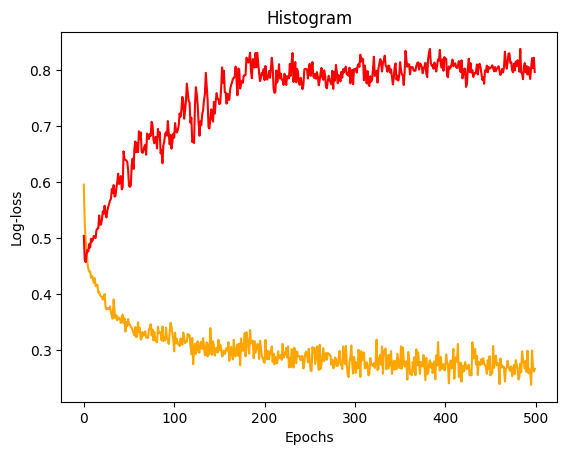

In [134]:
plt.plot(loss_epochs_train, color = 'orange')
plt.plot(loss_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

### Model Validation <a class="anchor" id="valid"></a>

As the last step of this project, we will cross-validate the performance of the following multilayer perceptron with three hidden layers. 

In [135]:
class Multi_Perceptron_Net_deep_final(nn.Module):
    def __init__(self, input_size, n_hidden, p_dropout1, p_dropout2):
        super().__init__()
        self.log_reg_stack = nn.Sequential(
            nn.Dropout(p_dropout1),
            nn.Linear(input_size, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout2),
            nn.Linear(n_hidden, 1), 
            nn.Sigmoid()
        )
    
    def forward(self, x):
        output = self.log_reg_stack(x)
        return output

In [136]:
torch.manual_seed(123)
multi_percp_3deep_10_bn = Multi_Perceptron_Net_deep_final(17, 10, 0.1, 0.5)
multi_percp_3deep_10_bn.apply(init_weights_he) 

n_epochs = 500

loss_epochs_train = np.zeros(n_epochs) 
loss_epochs_test = np.zeros(n_epochs) 
learning_rates = np.zeros(n_epochs)

heart_loader_train = DataLoader(dataset = heart_pytorch_dataset_train, batch_size = 200, shuffle = True) 
optim_SGD =  torch.optim.SGD(multi_percp_3deep_10_bn.parameters(), lr = 0.001, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optim_SGD, total_iters = n_epochs, power = 2)

start = time.time()
for t in range(n_epochs):
    loss_epochs_train[t], loss_epochs_test[t], learning_rates[t] = train_test_loop_clipping(heart_loader_train, X_test, y_test, multi_percp_3deep_10_bn, logistic_loss, optim_SGD, scheduler, 1)
end = time.time()
print(end - start)

10.781244993209839


We did not systematically explore the hyperparameters/ We just picked the combination of hyperparameter values (learning rates, dropout probabilities, batch sizes), will we got a reasonable convergence of training and test errors.

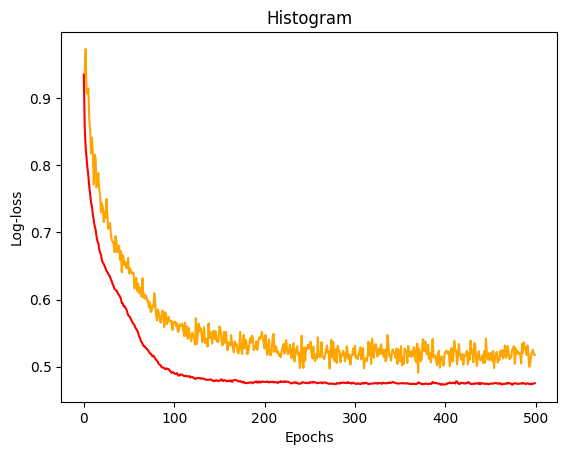

In [137]:
plt.plot(loss_epochs_train, color = 'orange')
plt.plot(loss_epochs_test, color = 'red')
plt.title('Histogram')
plt.xlabel('Epochs')
plt.ylabel('Log-loss');

In [138]:
log_loss(y_test.detach(), multi_percp_3deep_10_bn(X_test).detach())

0.47530508842554375

In [139]:
brier_score_loss(y_test.detach(), multi_percp_3deep_10_bn(X_test).detach())

0.15280866223590123

In [140]:
roc_auc_score(y_test.detach(), multi_percp_3deep_10_bn(X_test).detach())

0.8508522727272728

Let us cross-validate our performance metrics.

In [141]:
from sklearn.model_selection import KFold

np.random.seed(123)
torch.manual_seed(123)

rep = 50
folds = 10
kf = KFold(n_splits=10) # create folds

metrics_cv =  pd.DataFrame(index=range(rep*folds),columns = ['Balanced Accuracy','Matthews Correlation','AUC','Brier score', 'Log loss', 'Calibration'])

k = 0

for i in range(rep):
    
    idx_cv = np.random.choice([*range(len(heart_final))],len(heart_final), replace=False)
    
    for j, (train_index, test_index) in enumerate(kf.split(idx_cv)):
        
        train_set = idx_cv[train_index]
        test_set = idx_cv[test_index]

        heart_train = heart_final.iloc[train_set]
        heart_test = heart_final.iloc[test_set]

        X_train_new = heart_train.iloc[:,range(0,17)]
        X_test_new = heart_test.iloc[:,range(0,17)]
        y_train_new = heart_train['heart_disease']
        y_test_new = heart_test['heart_disease']

        scaler_train = StandardScaler().fit(X = X_train_new)
        heart_train_final_scaled_new = pd.DataFrame(scaler_train.transform(X_train_new))
        heart_test_final_scaled_new = pd.DataFrame(scaler_train.transform(X_test_new))

        X_train_new = torch.from_numpy(heart_train_final_scaled_new.values).type(torch.float)
        X_test_new = torch.from_numpy(heart_test_final_scaled_new.values).type(torch.float)
        y_train_new = torch.from_numpy(y_train_new.values).type(torch.LongTensor)
        y_test_new = torch.from_numpy(y_test_new.values).type(torch.LongTensor)

        heart_pytorch_dataset_train_new = TensorDataset(X_train_new, y_train_new)

        multi_percp_3deep_10_bn_new = Multi_Perceptron_Net_deep_final(17, 10, 0.1, 0.5)
        multi_percp_3deep_10_bn_new.apply(init_weights_he) 

        n_epochs = 500

        heart_loader_train_new = DataLoader(dataset = heart_pytorch_dataset_train_new, batch_size = 200, shuffle = True) 
        optim_SGD_new =  torch.optim.SGD(multi_percp_3deep_10_bn_new.parameters(), lr = 0.001, momentum = 0.9)
        scheduler_new = torch.optim.lr_scheduler.PolynomialLR(optim_SGD_new, total_iters = n_epochs, power = 2)

        start = time.time()
        for t in range(n_epochs):
            train_test_loop_clipping(heart_loader_train_new, X_test_new, y_test_new, multi_percp_3deep_10_bn_new, logistic_loss, optim_SGD_new, scheduler_new, 1)
        end = time.time()

        logitp_tree_heart_new = np.log(np.clip(multi_percp_3deep_10_bn_new(X_test).detach().numpy(),1e-8,1- 1e-8)/(1-np.clip(multi_percp_3deep_10_bn_new(X_test).detach().numpy(),1e-8,1- 1e-8)))
        
        if multi_percp_3deep_10_bn_new(X_test).isnan().any() == False:

            metrics_cv.iloc[k,0] = balanced_accuracy_score(y_test.detach(),multi_percp_3deep_10_bn_new(X_test).detach()>0.5)
            metrics_cv.iloc[k,1] = matthews_corrcoef(y_test.detach(),multi_percp_3deep_10_bn_new(X_test).detach()>0.5)
            metrics_cv.iloc[k,2] = roc_auc_score(y_test.detach(),multi_percp_3deep_10_bn_new(X_test).detach())
            metrics_cv.iloc[k,3] = brier_score_loss(y_test.detach(),multi_percp_3deep_10_bn_new(X_test).detach())
            metrics_cv.iloc[k,4] = log_loss(y_test.detach(),multi_percp_3deep_10_bn_new(X_test).detach())
            metrics_cv.iloc[k,5] = sm.Logit(endog= y_test.detach(),exog = pd.DataFrame(logitp_tree_heart_new).assign(const=1)).fit(disp=0).params.iloc[0]

        k = k + 1

metrics_cv.mean()

Balanced Accuracy       0.820865
Matthews Correlation    0.647991
AUC                      0.87445
Brier score             0.140917
Log loss                0.446645
Calibration             1.220559
dtype: object

We see that we obtained a model that is significantly better than logistic regression and somewhat close to gradient boosted trees (see the Third Circle Part One). With this observation, we end this project. In the next parts, we will investigate other more specialized neural network architectures. We start with convolutional networks that are mostly associated with image recognition.

## References <a class="anchor" id="references"></a>

<a id="1">[1]</a> DETRANO, Robert, et al. International application of a new probability algorithm for the diagnosis of coronary artery disease. *The American journal of cardiology*, 1989, 64.5: 304-310.

<a id="2">[2]</a> HASTIE, Trevor, et al. *The Elements of Statistical Learning: Data Mining, Inference, and Prediction, Second Edition*. Springer New York, NY. 2009.

<a id="3">[3]</a> ROSENBLATT, Frank. The perceptron: a probabilistic model for information storage and organization in the brain. *Psychological review*, 1958, 65.6: 386.

<a id="4">[4]</a> ZHANG, Aston, et al. *Dive into deep learning*. Cambridge University Press, 2023.

<a id="5">[5]</a> GARRIGOS, Guillaume; GOWER, Robert M. Handbook of convergence theorems for (stochastic) gradient methods. *arXiv preprint arXiv:2301.11235*, 2023.

<a id="6">[6]</a> NOCEDAL, Jorge; WRIGHT, Stephen J. *Numerical optimization*. New York, NY: Springer New York, 2006.

<a id="7">[7]</a> ALLEN-ZHU, Zeyuan; LI, Yuanzhi; SONG, Zhao. A convergence theory for deep learning via over-parameterization. In: International conference on machine learning. PMLR, 2019. p. 242-252.

<a id="8">[8]</a> GLOROT, Xavier; BENGIO, Yoshua. Understanding the difficulty of training deep feedforward neural networks. In: Proceedings of the thirteenth international conference on artificial intelligence and statistics. *JMLR Workshop and Conference Proceedings*, 2010. p. 249-256.

<a id="9">[9]</a> HE, Kaiming, et al. Delving deep into rectifiers: Surpassing human-level performance on imagenet classification. In: *Proceedings of the IEEE international conference on computer vision*. 2015. p. 1026-1034.

<a id="10">[10]</a> SRIVASTAVA, Nitish, et al. Dropout: a simple way to prevent neural networks from overfitting. The journal of machine learning research, 2014, 15.1: 1929-1958.

<a id="11">[11]</a> IOFFE, Sergey; SZEGEDY, Christian. Batch normalization: Accelerating deep network training by reducing internal covariate shift. In: *International conference on machine learning.* 2015. p. 448-456.

<a id="12">[12]</a> SANTURKAR, Shibani, et al. How does batch normalization help optimization?. Advances in neural information processing systems, 2018, 31.